# Read me

This script includes the following 

Calculation of AOU in Along Track Distance, time and density against depth. 

Transformation of time (dates) to yearday.

Calculation of Mixed Layer Depth.

Animation of SST, SST gradient, EKE, ADT, SLA with glider position.

Plots of mean SST and EKE with glider track.

T-S plot 

Combined figure T, S, DO and AOU. 



# Packages


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd
import csv
import sys
import array
import xarray as xr
import cmocean.cm as cmocean
def write_with_byte_inversion(f, tab):
    tab2write = array.array('f', tab.T.flatten())
    if sys.byteorder == 'little':
        tab2write.byteswap()
    f.write(tab2write)

dtype=np.float32
#topo_adjust to topo wi
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
import pathlib
from pathlib import Path
import os
import netCDF4
from netCDF4 import Dataset as nc

import glob
from glob import glob
import glidertools as gt
import gsw
from scipy.interpolate import griddata
import cmocean
import cmocean.cm as cmo

# AOU gridded on ATD

In [2]:
ds_work = xr.open_dataset('ds_ATD.nc')

In [3]:
density = gsw.sigma0(ds_work.salinity, ds_work.temp)

In [4]:
AOU = ds_work.sol - ds_work.o2

# Transform time to Yearday

In [5]:
from datetime import datetime

# Define the start date of the year and the given date
start_of_year = datetime(2023, 1, 1)
given_date = datetime(2023, 3, 22, 8, 33, 43)

# Calculate the difference in days
difference = given_date - start_of_year

# The difference will be a timedelta object, so you can get the total number of seconds and convert to days
days_passed = difference.total_seconds() / (24 * 3600)

# Print the result rounded to 2 decimal places
print(f"Days passed since the start of the year: {days_passed:.2f}")



Days passed since the start of the year: 80.36


In [6]:
ds_work['year_day'] = ds_work['time'] + days_passed

In [7]:
# Define a function to convert yearday to datetime in 2023
def yearday_to_date(yearday):
    return pd.Timestamp('2023-01-01') + pd.to_timedelta(yearday, unit='D')

# Apply the function to convert all yearday values to dates in 2023
dates_2023 = [yearday_to_date(yd) for yd in ds_work.year_day.values]

# Assign the new dates back to ds_work.time
ds_work['time'] = ('ATD', dates_2023)

#ds_work


# mixed layer depth

In [8]:
import numpy as np
import xarray as xr
import gsw

mixed_layer_densities = []

for i in range(len(ds_work.ATD)):
    # Calculate density for the current ATD point
    density = gsw.sigma0(ds_work.salinity.isel(ATD=i), ds_work.temp.isel(ATD=i)).expand_dims(ATD=ds_work.ATD)
    
    # Select reference depth based on the value of ATD
    if ds_work.ATD.isel(ATD=i).item() == 0:
        reference_depth = 13
    else:
        reference_depth = 10
    
    # Calculate the reference density at the chosen reference depth
    reference_density = density.sel(ctd_depth=reference_depth)
    density_difference = density - reference_density
    
    # Find the index where the difference is greater than the threshold for the first time
    mixed_layer_index_flat = np.argmax((density_difference > 0.03).values)
    
    # Get the depth index where the difference is greater than the threshold for the first time
    mixed_layer_index = mixed_layer_index_flat.item()
    
    # Get the density value at that depth for the current ATD point
    mixed_layer_density = density.isel(ctd_depth=mixed_layer_index, ATD=i)
    
    # Append the mixed layer density directly to the list
    mixed_layer_densities.append(mixed_layer_density)

# Concatenate the list of mixed layer densities along the ATD dimension
mixed_layer_densities = xr.concat(mixed_layer_densities, dim=ds_work.ATD)

#mixed_layer_densities


In [9]:
# NaN zero values
mixed_layer_densities['ctd_depth'] = mixed_layer_densities['ctd_depth'].where(mixed_layer_densities['ctd_depth'] != 0.0, np.nan)
mixed_layer_densities['ctd_depth'] = mixed_layer_densities['ctd_depth'].where(mixed_layer_densities['ctd_depth'] != 0., np.nan)

In [10]:
MLD = mixed_layer_densities.ctd_depth

 # Combined figure T, S, Oxygen, AOU

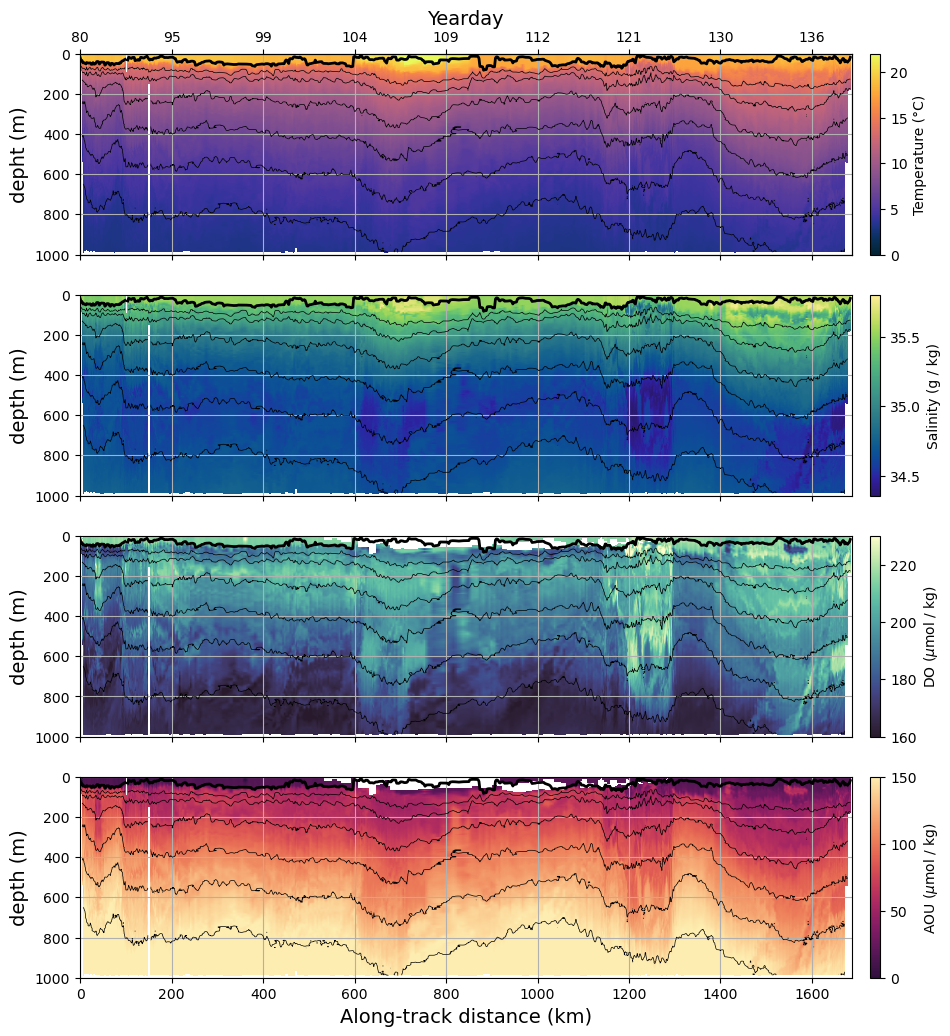

In [11]:
fig, ax = plt.subplots(4, figsize=(12, 12), sharex=True)

vmin = 160
vmax = 230

density = gsw.sigma0(ds_work.salinity, ds_work.temp)
AOU = ds_work.sol - ds_work.o2

# Create the bar chart
img0 = ax[0].pcolormesh(ds_work.ATD, ds_work.ctd_depth, ds_work.temp, cmap = cmo.thermal, vmin =0, vmax =22)
img1 = ax[1].pcolormesh(ds_work.ATD, ds_work.ctd_depth, ds_work.salinity, cmap = cmo.haline)
img2 = ax[2].pcolormesh(ds_work.ATD, ds_work.ctd_depth, ds_work.o2, cmap = cmo.deep_r, vmin =160, vmax=230)
img3 = ax[3].pcolormesh(ds_work.ATD, ds_work.ctd_depth, AOU, cmap = cmo.matter_r, vmin = 0, vmax = 150)

[a.invert_yaxis() for a in ax]
# Add colorbars to the plots
cbar0 = plt.colorbar(img0, ax=ax[0], pad=0.02)
cbar0.set_label('Temperature (°C)')

cbar1 = plt.colorbar(img1, ax=ax[1], pad=0.02)
cbar1.set_label('Salinity (g / kg)')

cbar2 = plt.colorbar(img2, ax=ax[2], pad=0.02)
cbar2.set_label(r'DO ($\mu$mol / kg)')

cbar3 = plt.colorbar(img3, ax=ax[3], pad=0.02)
cbar3.set_label(r'AOU ($\mu$mol / kg)')

ax[3].set_xlabel('Along-track distance (km)')
ax[0].set_ylabel('depht (m)')
ax[1].set_ylabel('depth (m)')
ax[2].set_ylabel('depth (m)')
ax[3].set_ylabel('depth (m)')

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

# Generate levels for the contour lines
# Specify the beginning, ending, and spacing
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

ax[0].contour(ds_work.ATD, ds_work.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax[1].contour(ds_work.ATD, ds_work.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax[2].contour(ds_work.ATD, ds_work.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax[3].contour(ds_work.ATD, ds_work.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

ax[0].plot(mixed_layer_densities.ATD, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[1].plot(mixed_layer_densities.ATD, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[2].plot(mixed_layer_densities.ATD, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
ax[3].plot(mixed_layer_densities.ATD, mixed_layer_densities.ctd_depth, color='k', linewidth =2)


# Increase font sizes for all text and numbers
plt.rcParams.update({'font.size': 14})  # Set the default font size

# Set the xlabel on the top
ax0 = ax[0].twiny()
ax0.set_xlabel('Yearday')



tick_positions = np.arange(0, max(ds_work.ATD), 200)
tick_labels = ds_work.year_day[np.searchsorted(ds_work.ATD, tick_positions)].astype(int)  # Convert to integers
ax0.set_xlim(ax[0].get_xlim())
ax0.set_xticks(tick_positions)
ax0.set_xticklabels([f'{t:.0f}' for t in tick_labels])

ax0.tick_params(axis='x', which='major', labelsize='10')

# Set font sizes for specific elements
for a in ax:
    a.set_title(a.get_title(), fontsize=14)  # Increase title font size
    a.set_xlabel(a.get_xlabel(), fontsize=14)  # Increase x-axis label font size
    a.set_ylabel(a.get_ylabel(), fontsize=14)  # Increase y-axis label font size
    a.tick_params(axis='both', which='major', labelsize=10)  # Increase tick label font size
    

# Save the figure
plt.savefig('Combined.png', bbox_inches='tight', dpi=100)

# Make dataset dependend on dates

In [12]:

from datetime import datetime, timedelta
# Load your dataset

ds_date = xr.open_dataset('ds_time.nc')

# Define start and end datetime objects
start_date = datetime(2023, 3, 22, 8, 33, 43)
end_date = datetime(2023, 5, 23, 15, 45, 43)

# Calculate timedelta
time_delta = end_date - start_date

# Convert time coordinates from days to datetime objects
ds_date['time'] = [start_date + timedelta(days=float(day)) for day in ds_date['time']]

# Show updated dataset
print(ds_date)

<xarray.Dataset>
Dimensions:    (ctd_depth: 2001, time: 624)
Coordinates:
  * ctd_depth  (ctd_depth) float64 0.0 0.5 1.0 1.5 ... 998.5 999.0 999.5 1e+03
  * time       (time) datetime64[ns] 2023-03-22T08:33:43 ... 2023-05-23T15:45:43
    long       (time) float64 ...
    lat        (time) float64 ...
    distance   (time) float64 ...
Data variables:
    temp       (ctd_depth, time) float64 ...
    salinity   (ctd_depth, time) float64 ...
    o2         (ctd_depth, time) float64 ...
    sol        (ctd_depth, time) float64 ...
    p          (ctd_depth, time) float64 ...
Attributes:
    description:  dataset including gridded data time and cleaned variables


# AOU analyzation between 300m to 700m

In [13]:
# Define the depth range with MLD
#depth_min = mixed_layer_densities.ctd_depth
#depth_max = mixed_layer_densities.ctd_depth + 100

depth_min = 300
depth_max = 700


# Select AOU values within the depth range
AOU_subset = AOU.where((AOU.ctd_depth >= depth_min) & (AOU.ctd_depth <= depth_max), drop=True)



# location glider and changing SLA + ADT + u and v geostrophic

### SLA changing over time 

In [14]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import Normalize
import mpl_toolkits.axes_grid1


# Define start and end dates
start_date = pd.to_datetime("2023-03-22").strftime('%Y-%m-%d')
end_date = pd.to_datetime("2023-05-23").strftime('%Y-%m-%d')


# vmin and vmax
vmin = -2.0
vmax = 2.0
#cmap = 'balance'

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)

    
# Initialize a list to store image paths
image_paths = []

# Iterate over the dates
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Calculate EKE
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)

    latitude = ds['latitude']
    longitude = ds['longitude']
    # Extract sea surface height data for the specified region
    ssh_subset = ds['sla'].sel(latitude=lat_range, longitude=lon_range) # (Sea Level Anomaly)
    adt_subset = ds['adt'].sel(latitude=lat_range, longitude=lon_range) # (ADT)
    
    plt.figure(figsize=(10, 8)) # Adjust the figure size to make space for the title
    # Create a map projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Plot the data on the map with fixed colorbar range and colormap
    plt.contourf(ssh_subset.longitude, ssh_subset.latitude, ssh_subset.isel(time=0),
                 transform=ccrs.PlateCarree(), cmap=cmo.balance, levels=np.arange(vmin, vmax, 0.1))
    plt.colorbar(label='Sea Level Anomaly (m)')
    
    # Add the thick black contour line
    plt.contour(adt_subset.longitude, adt_subset.latitude, adt_subset.isel(time=0),
                levels=[0.7], colors='black', linewidths=2, transform=ccrs.PlateCarree())
 
    
  
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Set labels and title
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    

    # Plot quiver plot
    plt.quiver(ds.longitude.sel(longitude=lon_range),
                       ds.latitude.sel(latitude=lat_range), ugos.isel(time=0), vgos.isel(time=0), color='grey', linewidth=2)
    
    # Convert the date strings to pandas Timestamps for comparison
    current_date_timestamp = pd.Timestamp(current_date)
    ds_work_lat_times = pd.to_datetime(ds_work['lat'].time)

    # Find the index of the nearest time
    nearest_time_index = np.abs(ds_work_lat_times - current_date_timestamp).argmin()

    # Get the latitude and longitude corresponding to the nearest time
    lat = ds_work['lat'].isel(ATD=nearest_time_index)
    lon = ds_work['long'].isel(ATD=nearest_time_index)

    # Convert current_date to a NumPy datetime object
    current_date = np.datetime64(current_date)
    
    # First day of the year
    first_day_of_year = np.datetime64('2023-01-01')

    # Calculate the difference in days (0-based indexing)
    yearday = (current_date - first_day_of_year).astype('timedelta64[D]').astype(int)
    
    # Convert the current date to a string
    #day = np.datetime_as_string(yearday, unit='D')
    
    day = yearday
        
    # Add the current date as a title above the graph
    #day = np.datetime_as_string(current_date, unit='D')
    plt.title(f'SLA DOY {day}', pad=30)
    

    # Normalize the colormap based on the levels
    norm = Normalize(vmin=levels.min(), vmax=levels.max())

    # Plot scatter points for latitude and longitude
    scatter = ax.scatter(lon, lat, label='location glider')
    

    # Show legend in the top right corner
    plt.legend(loc='upper right', bbox_to_anchor=(0.97, 0.95), borderaxespad=0.)
    
    plt.grid(True) 
    
    
    
    # Save the plot as an image
    day = np.datetime_as_string(current_date, unit='D')
    image_path = f"SLA/sla_{day}.png"
    plt.savefig(image_path)
    plt.close()  # Close the plot to prevent displaying each plot

    image_paths.append(image_path)



# Combine the images into a GIF
images = [Image.open(image_path) for image_path in image_paths]
gif_path = "SLA/sla.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=500, loop=0)

print(f"GIF saved at: {gif_path}")


GIF saved at: SLA/sla.gif


### SLA including trajectory of glider

In [15]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import Normalize
import cmocean.cm as cmo

# Define start and end dates
start_date = pd.to_datetime("2023-03-22").strftime('%Y-%m-%d')
end_date = pd.to_datetime("2023-05-23").strftime('%Y-%m-%d')

# vmin and vmax
vmin = -2.0
vmax = 2.0

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)

# Initialize a list to store image paths
image_paths = []

# Initialize lists to store cumulative latitudes and longitudes
cumulative_lat = []
cumulative_lon = []

# Iterate over the dates
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Calculate EKE
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)

    latitude = ds['latitude']
    longitude = ds['longitude']
    # Extract sea surface height data for the specified region
    ssh_subset = ds['sla'].sel(latitude=lat_range, longitude=lon_range) # (Sea Level Anomaly)
    adt_subset = ds['adt'].sel(latitude=lat_range, longitude=lon_range) # (ADT)
    
    plt.figure(figsize=(10, 8)) # Adjust the figure size to make space for the title
    # Create a map projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Plot the data on the map with fixed colorbar range and colormap
    plt.contourf(ssh_subset.longitude, ssh_subset.latitude, ssh_subset.isel(time=0),
                 transform=ccrs.PlateCarree(), cmap=cmo.balance, levels=np.arange(vmin, vmax, 0.1))
    #plt.colorbar(label='Sea Level Anomaly (m)')
    
    # Add the thick black contour line
    plt.contour(adt_subset.longitude, adt_subset.latitude, adt_subset.isel(time=0),
                levels=[0.7], colors='black', linewidths=2, transform=ccrs.PlateCarree())
 
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Set labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Plot quiver plot
    plt.quiver(ds.longitude.sel(longitude=lon_range),
               ds.latitude.sel(latitude=lat_range), ugos.isel(time=0), vgos.isel(time=0), color='grey', linewidth=2)
    
    # Convert the date strings to pandas Timestamps for comparison
    current_date_timestamp = pd.Timestamp(current_date)
    ds_work_lat_times = pd.to_datetime(ds_work['lat'].time)

    # Find the index of the nearest time
    nearest_time_index = np.abs(ds_work_lat_times - current_date_timestamp).argmin()

    # Get the latitude and longitude corresponding to the nearest time
    lat = ds_work['lat'].isel(ATD=nearest_time_index)
    lon = ds_work['long'].isel(ATD=nearest_time_index)

    # Store the latitude and longitude
    cumulative_lat.append(lat)
    cumulative_lon.append(lon)

    # Convert current_date to a NumPy datetime object
    current_date = np.datetime64(current_date)
    
    # First day of the year
    first_day_of_year = np.datetime64('2023-01-01')

    # Calculate the difference in days (0-based indexing)
    yearday = (current_date - first_day_of_year).astype('timedelta64[D]').astype(int)
    
    # Add the current date as a title above the graph
    plt.title(f'SLA DOY {yearday}', pad=30)
    
    # Plot scatter points for latitude and longitude
    scatter = ax.scatter(cumulative_lon, cumulative_lat, label='location glider', color='black')
    
    # Connect the dots with a thin black line
    ax.plot(cumulative_lon, cumulative_lat, color='black', linewidth=1)
    
    # Show legend in the top right corner
    plt.legend(loc='upper right', bbox_to_anchor=(0.97, 0.95), borderaxespad=0.)
    
    plt.grid(True) 
    
    # Save the plot as an image
    day = np.datetime_as_string(current_date, unit='D')
    image_path = f"SLA/sla_{day}.png"
    plt.savefig(image_path)
    plt.close()  # Close the plot to prevent displaying each plot

    image_paths.append(image_path)

# Combine the images into a GIF
images = [Image.open(image_path) for image_path in image_paths]
gif_path = "SLA/sla.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=500, loop=0)

print(f"GIF saved at: {gif_path}")



GIF saved at: SLA/sla.gif


### ADT over time

In [16]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import Normalize
import mpl_toolkits.axes_grid1


# Define start and end dates
start_date = pd.to_datetime("2023-03-22").strftime('%Y-%m-%d')
end_date = pd.to_datetime("2023-05-23").strftime('%Y-%m-%d')


# vmin and vmax
vmin = -2.0
vmax = 2.0
#cmap = 'balance'

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)

    
# Initialize a list to store image paths
image_paths = []

# Iterate over the dates
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Calculate EKE
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)

    latitude = ds['latitude']
    longitude = ds['longitude']
    # Extract sea surface height data for the specified region
    #ssh_subset = ds['sla'].sel(latitude=lat_range, longitude=lon_range) # (Sea Level Anomaly)
    adt_subset = ds['adt'].sel(latitude=lat_range, longitude=lon_range) # (ADT)
    
    plt.figure(figsize=(10, 8)) # Adjust the figure size to make space for the title
    # Create a map projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    # Plot the data on the map with fixed colorbar range and colormap
    plt.contourf(adt_subset.longitude, adt_subset.latitude, adt_subset.isel(time=0),
                 transform=ccrs.PlateCarree(), cmap=cmo.balance, levels=np.arange(vmin, vmax+ 0.01, 0.01))
    plt.colorbar(label='Sea Level Anomaly (m)')
    
    # Add the thick black contour line
    plt.contour(adt_subset.longitude, adt_subset.latitude, adt_subset.isel(time=0),
                levels=[0.7], colors='black', linewidths=2, transform=ccrs.PlateCarree())
 
    
  
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Set labels and title
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    

    # Plot quiver plot
    plt.quiver(ds.longitude.sel(longitude=lon_range),
                       ds.latitude.sel(latitude=lat_range), ugos.isel(time=0), vgos.isel(time=0), color='grey')
    
    # Convert the date strings to pandas Timestamps for comparison
    current_date_timestamp = pd.Timestamp(current_date)
    ds_work_lat_times = pd.to_datetime(ds_work['lat'].time)

    # Find the index of the nearest time
    nearest_time_index = np.abs(ds_work_lat_times - current_date_timestamp).argmin()

    # Get the latitude and longitude corresponding to the nearest time
    lat = ds_work['lat'].isel(ATD=nearest_time_index)
    lon = ds_work['long'].isel(ATD=nearest_time_index)

    # Convert current_date to a NumPy datetime object
    current_date = np.datetime64(current_date)

    # Convert the current date to a string
    day = np.datetime_as_string(current_date, unit='D')
        
    # Add the current date as a title above the graph
    day = np.datetime_as_string(current_date, unit='D')
    plt.title(f'ADT and Geostrophic Currents on {day}', pad=30)
    
    # Group AOU_subset by the 'ATD' dimension
    AOU_grouped = AOU_subset.groupby('ATD')

    # Compute the mean over 'ctd_depth' for each group
    AOU_mean = AOU_grouped.mean(dim='ctd_depth')

    AOU_value = AOU_mean.isel(ATD=nearest_time_index)

    # Define the levels
    levels = np.arange(20, 90, 0.1)

    # Normalize the colormap based on the levels
    norm = Normalize(vmin=levels.min(), vmax=levels.max())

    # Plot scatter points for latitude and longitude
    scatter = ax.scatter(lon, lat, s=50, c=AOU_value, cmap=cmo.deep_r, norm=norm, label='location glider')
    

    # Add colorbar at the bottom with specified levels
    cbar = plt.colorbar(scatter, orientation='horizontal', ticks=np.arange(20, 90, 10))
    cbar.set_label('AOU Value')  # Label for the colorbar

    # Show legend in the top right corner
    plt.legend(loc='upper right', bbox_to_anchor=(0.97, 0.95), borderaxespad=0.)
    
    plt.grid(True) 
    
    
    
    # Save the plot as an image
    day = np.datetime_as_string(current_date, unit='D')
    image_path = f"ADT/adt_{day}.png"
    plt.savefig(image_path)
    plt.close()  # Close the plot to prevent displaying each plot

    image_paths.append(image_path)



# Combine the images into a GIF
images = [Image.open(image_path) for image_path in image_paths]
gif_path = "ADT/adt.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=500, loop=0)

print(f"GIF saved at: {gif_path}")


GIF saved at: ADT/adt.gif


### EKE over time

In [157]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define start and end dates
start_date = pd.to_datetime("2023-03-22").strftime('%Y-%m-%d')
end_date = pd.to_datetime("2023-05-23").strftime('%Y-%m-%d')

# vmin and vmax
vmin = 0
vmax = 1
cmap = 'viridis'

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)

# Initialize a list to store image paths
image_paths = []

# Initialize lists to store ugos and vgos data for mean calculation
ugos_list = []
vgos_list = []

# Iterate over the dates to collect data for mean calculation
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Select ugos and vgos for the specified region
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)
    
    # Append data to the lists for mean calculation
    ugos_list.append(ugos)
    vgos_list.append(vgos)

# Concatenate all data arrays along the time dimension
ugos_all = xr.concat(ugos_list, dim='time')
vgos_all = xr.concat(vgos_list, dim='time')

# Calculate the mean over time
ugos_mean = ugos_all.mean(dim='time')
vgos_mean = vgos_all.mean(dim='time')

# Iterate over the dates again for calculating and plotting EKE
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Select ugos and vgos for the specified region
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)
    
    # Calculate the deviations from the mean
    ugos_anomaly = ugos - ugos_mean
    vgos_anomaly = vgos - vgos_mean
    
    # Calculate EKE
    eke = 0.5 * (ugos_anomaly**2 + vgos_anomaly**2)
    
    adt_subset = ds['adt'].sel(latitude=lat_range, longitude=lon_range)
    
    plt.figure()  # Adjust the figure size to make space for the title
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    plt.contourf(eke.longitude, eke.latitude, eke.isel(time=0), cmap=cmap, levels=np.linspace(vmin, vmax, 41), extend='both', transform=ccrs.PlateCarree())
    #plt.colorbar(label='EKE (m$^2$/s$^2$)', pad=0.2)

    # Add the thick black contour line
    plt.contour(adt_subset.longitude, adt_subset.latitude, adt_subset.isel(time=0), levels=[0.7], colors='black', linewidths=2, transform=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Set labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Plot quiver plot using the mean ugos and vgos
    plt.quiver(ugos.longitude, ugos.latitude, ugos_mean, vgos_mean, transform=ccrs.PlateCarree(), color= 'grey')
    
    # Convert the date strings to pandas Timestamps for comparison
    current_date_timestamp = pd.Timestamp(current_date)
    ds_work_lat_times = pd.to_datetime(ds_work['lat'].time)

    # Find the index of the nearest time
    nearest_time_index = np.abs(ds_work_lat_times - current_date_timestamp).argmin()

    # Get the latitude and longitude corresponding to the nearest time
    lat = ds_work['lat'].isel(ATD=nearest_time_index)
    lon = ds_work['long'].isel(ATD=nearest_time_index)

    # Convert current_date to a NumPy datetime object
    current_date = np.datetime64(current_date)
    
    # First day of the year
    first_day_of_year = np.datetime64('2023-01-01')

    # Calculate the difference in days (0-based indexing)
    yearday = (current_date - first_day_of_year).astype('timedelta64[D]').astype(int)
    
    # Convert the current date to a string
    #day = np.datetime_as_string(yearday, unit='D')
    
    day = yearday
        
    plt.title(f'EKE DOY {day}', pad=30)
    
    # Group AOU_subset by the 'ATD' dimension
    AOU_grouped = AOU_subset.groupby('ATD')

    # Compute the mean over 'ctd_depth' for each group
    AOU_mean = AOU_grouped.mean(dim='ctd_depth')

    AOU_value = AOU_mean.isel(ATD=nearest_time_index)

    # Define the levels
    levels = np.arange(50, 150, 0.1)

    # Normalize the colormap based on the levels
    norm = Normalize(vmin=levels.min(), vmax=levels.max())

    # Plot scatter points for latitude and longitude
    scatter = ax.scatter(lon, lat, s=100, c=AOU_value, cmap=cmo.matter_r, norm=norm, edgecolors='white', linewidths=1, label='location glider')
    

    # Add colorbar at the bottom with specified levels
    #cbar = plt.colorbar(scatter, orientation='horizontal', ticks=np.arange(50, 150, 10))
    #cbar.set_label('AOU Value')  # Label for the colorbar

    # Show legend in the top right corner
    plt.legend(loc='upper right', bbox_to_anchor=(0.97, 0.95), borderaxespad=0.)
    
    # Save the plot as an image
    day = np.datetime_as_string(current_date, unit='D')
    image_path = f"EKE/EKE_{day}.png"
    plt.savefig(image_path)
    plt.close()  # Close the plot to prevent displaying each plot

    image_paths.append(image_path)

# Combine the images into a GIF
images = [Image.open(image_path) for image_path in image_paths]
gif_path = "EKE/EKE.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=500, loop=0)

print(f"GIF saved at: {gif_path}")


GIF saved at: EKE/EKE.gif


### Mean KE

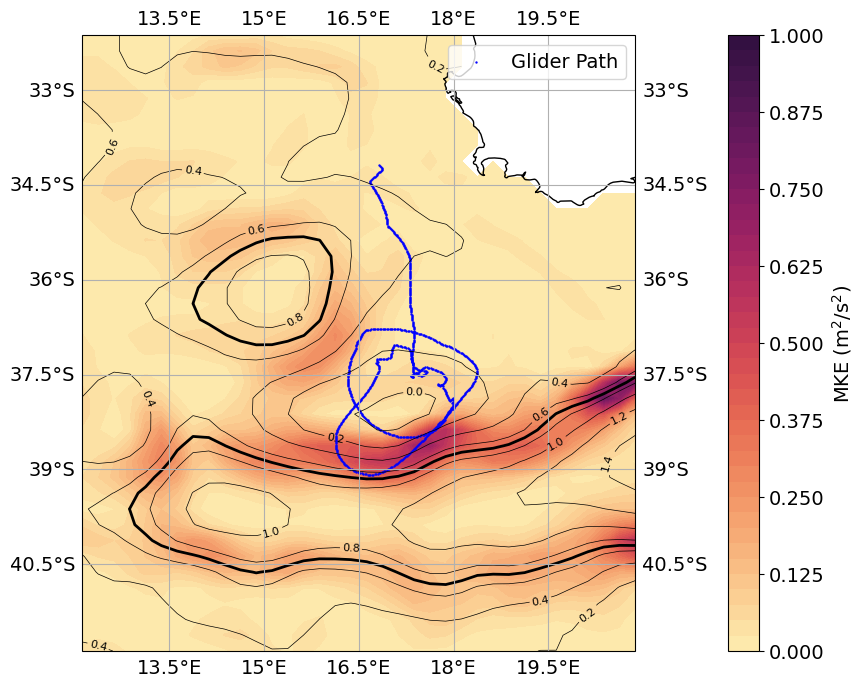

In [228]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define start and end dates
start_date = pd.to_datetime("2023-03-22").strftime('%Y-%m-%d')
end_date = pd.to_datetime("2023-05-23").strftime('%Y-%m-%d')

# vmin and vmax for EKE
vmin = 0
vmax = 1

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)


# Initialize lists to store datasets
#eke_datasets = []
adt_datasets = []

# Initialize lists to store ugos and vgos data for mean calculation
ugos_list = []
vgos_list = []

# Iterate over the dates to collect data for mean calculation
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Select ugos and vgos for the specified region
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)
    
    # Append data to the lists for mean calculation
    ugos_list.append(ugos)
    vgos_list.append(vgos)

# Concatenate all data arrays along the time dimension
ugos_all = xr.concat(ugos_list, dim='time')
vgos_all = xr.concat(vgos_list, dim='time')

# Calculate the mean over time
ugos_mean = ugos_all.mean(dim='time')
vgos_mean = vgos_all.mean(dim='time')


# Iterate over the dates
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Extract ADT data
    adt = ds['adt'].sel(latitude=lat_range, longitude=lon_range)
    adt_datasets.append(adt)
    
# MKE     
meke = 0.5 * (ugos_mean ** 2 + vgos_mean ** 2)
#eke_datasets.append(eke)

# Compute mean EKE and ADT over the period
#eke_mean = xr.concat(eke_datasets, dim='time').mean(dim='time')
adt_mean = xr.concat(adt_datasets, dim='time').mean(dim='time')

# Plot the mean EKE and ADT
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Create a custom colormap that starts from a less dark color
cmap = cmo.matter
cmap = cmap(np.linspace(0, 1, cmap.N))  # Shift the colormap to start from a lighter color
cmap = plt.cm.colors.ListedColormap(cmap)

# Plot the mean EKE
eke_plot = plt.contourf(meke.longitude, meke.latitude, meke, 
                        cmap=cmap, levels=np.linspace(vmin, vmax, 41), transform=ccrs.PlateCarree())

# Add colorbar
plt.colorbar(eke_plot, label='MKE (m$^2$/s$^2$)',pad=0.1)

# Plot the mean ADT with contours
adt_levels = np.arange(-0.2, 1.8, 0.2)
adt_contours = plt.contour(adt_mean.longitude, adt_mean.latitude, adt_mean, levels=adt_levels, 
                           colors='black', linestyles='-', linewidths=0.5, transform=ccrs.PlateCarree())
plt.clabel(adt_contours, fmt='%2.1f', colors='black', fontsize=8)

# Highlight the contour at ADT = 0.6 with a thicker line
adt_highlight_contour = plt.contour(adt_mean.longitude, adt_mean.latitude, adt_mean, levels=[0.7], 
                                    colors='black', linestyles='-', linewidths=2, transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Set labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Extract glider path (example data)
# Replace with your actual glider data
lat = ds_work['lat']
lon = ds_work['long']

# Add glider path
plt.scatter(lon, lat, color='blue', label='Glider Path', s=0.5)

# Show legend
plt.legend()

# Show plot
plt.show()


# SST from Ostia

In [17]:
# Define the file path pattern
file_path = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_1716288824368.nc"

ds_sst = xr.open_dataset(file_path)

#ds_sst

### SST gradient over time

In [125]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define start and end dates
start_date = pd.to_datetime("2023-03-22")
end_date = pd.to_datetime("2023-05-23")


# vmin and vmax
vmin = 0
vmax = 0.1
#cmap = 'balance'

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"


# Define the file path pattern
file_path_sst = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_1716288824368.nc"

ds_sst = xr.open_dataset(file_path_sst)

# Select latitude and longitude range
lat_range = slice(-41, -33)
lon_range = slice(12, 20)

    
# Initialize a list to store image paths
image_paths = []

# Iterate over the dates
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Calculate EKE
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)

    latitude = ds['latitude']
    longitude = ds['longitude']
    # Extract sea surface height data for the specified region
    ssh_subset = ds['sla'].sel(latitude=lat_range, longitude=lon_range) # (Sea Level Anomaly)
    adt_subset = ds['adt'].sel(latitude=lat_range, longitude=lon_range) # (ADT)
    
    plt.figure(figsize=(10, 6)) # Adjust the figure size to make space for the title
    # Create a map projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    
    # plot the SST 
    sst_subset = ds_sst['analysed_sst'].sel(latitude=lat_range, longitude=lon_range)
    
    sst_sel = sst_subset.sel(time=current_date, method='nearest')
    
    sst_sel_degree = sst_sel - 272.15
    
    # Compute the partial derivatives
    partial_lon = np.gradient(sst_sel_degree, axis=1)  # Gradient along longitude
    partial_lat = np.gradient(sst_sel_degree, axis=0)  # Gradient along latitude
    
    length_per_degree_lat = 111 # km
    
    length_per_degree_lon = 111 * np.cos(np.deg2rad(sst_sel_degree.latitude.values))
    
    # Convert the gradients to degrees per km
    partial_lon_per_km = partial_lon/0.05 / length_per_degree_lon
    partial_lat_per_km = partial_lat/0.05 / length_per_degree_lat

    # Sum the partial derivatives (now in degrees per km)
    tempgrad = np.absolute(partial_lon_per_km + partial_lat_per_km)
    
        
    ds_grad = xr.Dataset(
        {
            "tempgrad": (("latitude", "longitude"), tempgrad)
        },
        coords={
            "longitude":sst_sel_degree.longitude ,
            "latitude": sst_sel_degree.latitude
        }
    )
    
    
    plt.contourf(ds_grad.longitude, ds_grad.latitude, ds_grad.tempgrad, cmap=cmo.thermal, levels=np.linspace(vmin, vmax, 41), extend='both') 
    
    plt.colorbar(label='Temperature gradient (°C/km)', pad=0.1)
    
    # Add the thick black contour line
    plt.contour(adt_subset.longitude, adt_subset.latitude, adt_subset.isel(time=0),
                levels=[0.7], colors='black', linewidths=2, transform=ccrs.PlateCarree())
 
    
  
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Set labels and title
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    
   
    # Plot quiver plot
    plt.quiver(ds.longitude.sel(longitude=lon_range),
                       ds.latitude.sel(latitude=lat_range), ugos.isel(time=0), vgos.isel(time=0), color='grey')
    
    
    # Convert the date strings to pandas Timestamps for comparison
    current_date_timestamp = pd.Timestamp(current_date)
    ds_work_lat_times = pd.to_datetime(ds_work['lat'].time)

    # Find the index of the nearest time
    nearest_time_index = np.abs(ds_work_lat_times - current_date_timestamp).argmin()

    # Get the latitude and longitude corresponding to the nearest time
    lat = ds_work['lat'].isel(ATD=nearest_time_index)
    lon = ds_work['long'].isel(ATD=nearest_time_index)

    # Convert current_date to a NumPy datetime object
    current_date = np.datetime64(current_date)
    
    first_day_of_year = np.datetime64('2023-01-01')
    
    yearday = (current_date - first_day_of_year).astype('timedelta64[D]').astype(int)

    # Convert the current date to a string
    day = yearday
        
    plt.title(f'$\Delta$SST DOY {day}', pad=30)

    # Group AOU_subset by the 'ATD' dimension
    AOU_grouped = AOU_subset.groupby('ATD')

    # Compute the mean over 'ctd_depth' for each group
    AOU_mean = AOU_grouped.mean(dim='ctd_depth')

    AOU_value = AOU_mean.isel(ATD=nearest_time_index)

    # Define the levels
    levels = np.arange(50, 150, 0.1)

    # Normalize the colormap based on the levels
    norm = Normalize(vmin=levels.min(), vmax=levels.max())

    # Plot scatter points for latitude and longitude
    scatter = ax.scatter(lon, lat, s=100, c=AOU_value, cmap=cmo.matter_r, norm=norm, edgecolors='white', linewidths=1, label='location glider')
    

    # Add colorbar at the bottom with specified levels
    cbar = plt.colorbar(scatter, orientation='horizontal', ticks=np.arange(50, 150, 10))
    cbar.set_label('AOU Value')  # Label for the colorbar

    # Show legend in the top right corner
    plt.legend(loc='upper right', bbox_to_anchor=(0.97, 0.95), borderaxespad=0.)
    
    
    plt.grid(True) 
    
    
    
    # Save the plot as an image
    day = np.datetime_as_string(current_date, unit='D')
    image_path = f"SSTgrad/sst__grad{day}.png"
    plt.savefig(image_path)
    plt.close()  # Close the plot to prevent displaying each plot

    image_paths.append(image_path)



# Combine the images into a GIF
images = [Image.open(image_path) for image_path in image_paths]
gif_path = "SSTgrad/sst_grad.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=500, loop=0)

print(f"GIF saved at: {gif_path}")


GIF saved at: SSTgrad/sst_grad.gif


### SST over time

In [20]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define start and end dates
start_date = pd.to_datetime("2023-03-22").strftime('%Y-%m-%d')
end_date = pd.to_datetime("2023-05-23").strftime('%Y-%m-%d')


# vmin and vmax
vmin = 15
vmax = 25
#cmap = 'balance'

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)


# Define the file path pattern
file_path_sst = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_1716288824368.nc"

ds_sst = xr.open_dataset(file_path_sst)



    
# Initialize a list to store image paths
image_paths = []

# Iterate over the dates
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Calculate EKE
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)

    latitude = ds['latitude']
    longitude = ds['longitude']
    # Extract sea surface height data for the specified region
    ssh_subset = ds['sla'].sel(latitude=lat_range, longitude=lon_range) # (Sea Level Anomaly)
    adt_subset = ds['adt'].sel(latitude=lat_range, longitude=lon_range) # (ADT)
    
    plt.figure(figsize=(10, 6)) # Adjust the figure size to make space for the title
    # Create a map projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    
    # plot the SST 
    sst_subset = ds_sst['analysed_sst'].sel(latitude=lat_range, longitude=lon_range)
    
    sst_sel = sst_subset.sel(time=current_date, method='nearest')
    
    sst_sel_degree = sst_sel - 272.15
    

    plt.contourf(sst_sel_degree.longitude, sst_sel_degree.latitude, sst_sel_degree, cmap=cmo.thermal, levels=np.linspace(vmin, vmax, 41), extend='both') 
    
    plt.colorbar(label='SST (°C)', pad=0.1)
    
    # Add the thick black contour line
    plt.contour(adt_subset.longitude, adt_subset.latitude, adt_subset.isel(time=0),
                levels=[0.7], colors='black', linewidths=2, transform=ccrs.PlateCarree())
 
    
  
    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Set labels and title
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    
   
    # Plot quiver plot
    plt.quiver(ds.longitude.sel(longitude=lon_range),
                       ds.latitude.sel(latitude=lat_range), ugos.isel(time=0), vgos.isel(time=0), color='grey')
    
    
    # Convert the date strings to pandas Timestamps for comparison
    current_date_timestamp = pd.Timestamp(current_date)
    ds_work_lat_times = pd.to_datetime(ds_work['lat'].time)

    # Find the index of the nearest time
    nearest_time_index = np.abs(ds_work_lat_times - current_date_timestamp).argmin()

    # Get the latitude and longitude corresponding to the nearest time
    lat = ds_work['lat'].isel(ATD=nearest_time_index)
    lon = ds_work['long'].isel(ATD=nearest_time_index)

    # Convert current_date to a NumPy datetime object
    current_date = np.datetime64(current_date)
    
        
    first_day_of_year = np.datetime64('2023-01-01')
    
    yearday = (current_date - first_day_of_year).astype('timedelta64[D]').astype(int)

    # Convert the current date to a string
    day = yearday

        
    plt.title(f'SST DOY {day}', pad=30)

    # Group AOU_subset by the 'ATD' dimension
    AOU_grouped = AOU_subset.groupby('ATD')

    # Compute the mean over 'ctd_depth' for each group
    AOU_mean = AOU_grouped.mean(dim='ctd_depth')

    AOU_value = AOU_mean.isel(ATD=nearest_time_index)
    
    # Define the levels
    levels = np.arange(50, 150, 0.1)

    # Normalize the colormap based on the levels
    norm = Normalize(vmin=levels.min(), vmax=levels.max())

    # Plot scatter points for latitude and longitude
    scatter = ax.scatter(lon, lat, s=100, c=AOU_value, cmap=cmo.matter_r, norm=norm, edgecolors='white', linewidths=1, label='mean AOU 300-700m')
    

    # Add colorbar at the bottom with specified levels
    cbar = plt.colorbar(scatter, orientation='horizontal', ticks=np.arange(50, 150, 10))
    cbar.set_label('AOU Value')  # Label for the colorbar   


    # Show legend in the top right corner
    plt.legend(loc='upper right', bbox_to_anchor=(0.97, 0.95), borderaxespad=0.)
    
    
    plt.grid(True) 
    
    
    # Save the plot as an image
    day = np.datetime_as_string(current_date, unit='D')
    image_path = f"SST/sst_{day}.png"
    plt.savefig(image_path)
    plt.close()  # Close the plot to prevent displaying each plot

    image_paths.append(image_path)



# Combine the images into a GIF
images = [Image.open(image_path) for image_path in image_paths]
gif_path = "SST/sst.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=500, loop=0)

print(f"GIF saved at: {gif_path}")

GIF saved at: SST/sst.gif


### mean SST

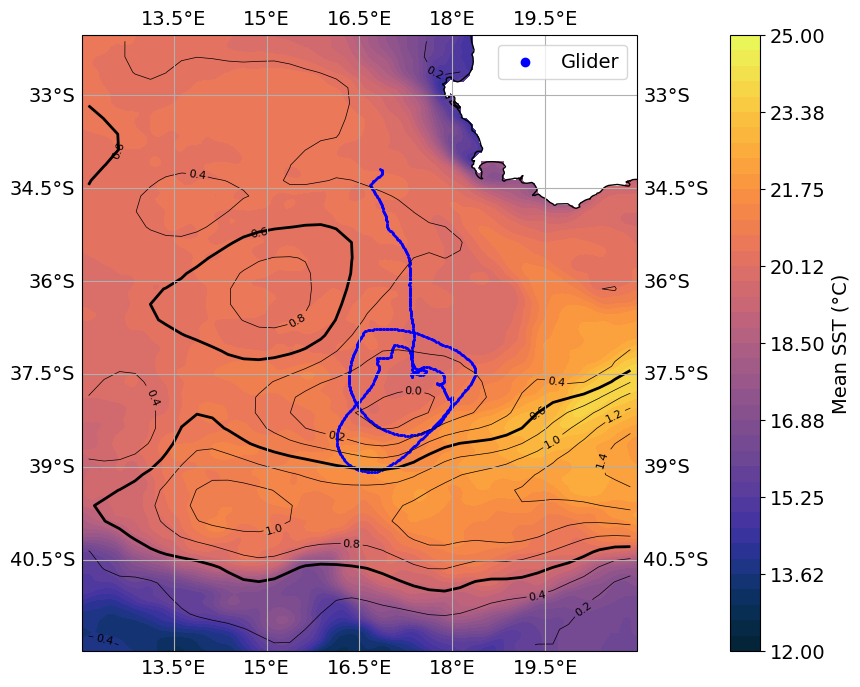

In [128]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define start and end dates
start_date = pd.to_datetime("2023-03-22").strftime('%Y-%m-%d')
end_date = pd.to_datetime("2023-05-23").strftime('%Y-%m-%d')

# vmin and vmax for EKE
vmin = 12
vmax = 25

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)

# Define the file path pattern
file_path_sst = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_1716288824368.nc"

ds_sst = xr.open_dataset(file_path_sst)



# Initialize lists to store datasets
SST_datasets = []
adt_datasets = []

# Iterate over the dates
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Calculate EKE
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)
    #eke = 0.5 * (ugos ** 2 + vgos ** 2)
    #eke_datasets.append(eke)
    
    # Extract ADT data
    adt = ds['adt'].sel(latitude=lat_range, longitude=lon_range)
    adt_datasets.append(adt)
    
    #  Extract SST data 
    sst_subset = ds_sst['analysed_sst'].sel(latitude=lat_range, longitude=lon_range)
    
    sst_sel_degree = sst_subset - 272.15
    SST_datasets.append(sst_sel_degree)
    


# Compute mean EKE and ADT over the period
#eke_mean = xr.concat(eke_datasets, dim='time').mean(dim='time')
adt_mean = xr.concat(adt_datasets, dim='time').mean(dim='time')
SST_mean = xr.concat(SST_datasets, dim='time').mean(dim='time')

# Plot the mean EKE and ADT
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Create a custom colormap that starts from a less dark color
cmap = cmo.matter
cmap = cmap(np.linspace(0, 1, cmap.N))  # Shift the colormap to start from a lighter color
cmap = plt.cm.colors.ListedColormap(cmap)

# Plot the mean EKE
SST_plot = plt.contourf(SST_mean.longitude, SST_mean.latitude, SST_mean, 
                        cmap=cmo.thermal, levels=np.linspace(vmin, vmax, 41), transform=ccrs.PlateCarree())

# Add colorbar
plt.colorbar(SST_plot, label='Mean SST (°C)', pad=0.1)

# Plot the mean ADT with contours
adt_levels = np.arange(-0.2, 1.8, 0.2)
adt_contours = plt.contour(adt_mean.longitude, adt_mean.latitude, adt_mean, levels=adt_levels, 
                           colors='black', linestyles='-', linewidths=0.5, transform=ccrs.PlateCarree())
plt.clabel(adt_contours, fmt='%2.1f', colors='black', fontsize=8)

# Highlight the contour at ADT = 0.6 with a thicker line
adt_highlight_contour = plt.contour(adt_mean.longitude, adt_mean.latitude, adt_mean, levels=[0.6], 
                                    colors='black', linestyles='-', linewidths=2, transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Set labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Extract glider path (example data)
# Replace with your actual glider data
lat = ds_work['lat']
lon = ds_work['long']

# Add glider path
plt.scatter(lon, lat, color='blue', label='Glider', s=1)

# Show legend
plt.legend(markerscale=6)

# Show plot
plt.show()


# SST plot against time and distance

In [20]:
SST_global = ds_sst.analysed_sst
#SST_global

In [21]:
# Load the datasets
analysed_sst = SST_global

# Interpolate SST at the locations and times of the temp dataset
sst_at_temp_locs = analysed_sst.interp(
    latitude=ds_work['lat'],
    longitude=ds_work['long'],
    time=ds_work['time'],
    method="linear"
)

# Now sst_at_temp_locs contains the SST values at the same times and locations as the temp dataset
SST_global_glider = sst_at_temp_locs - 272.15

### SST in time

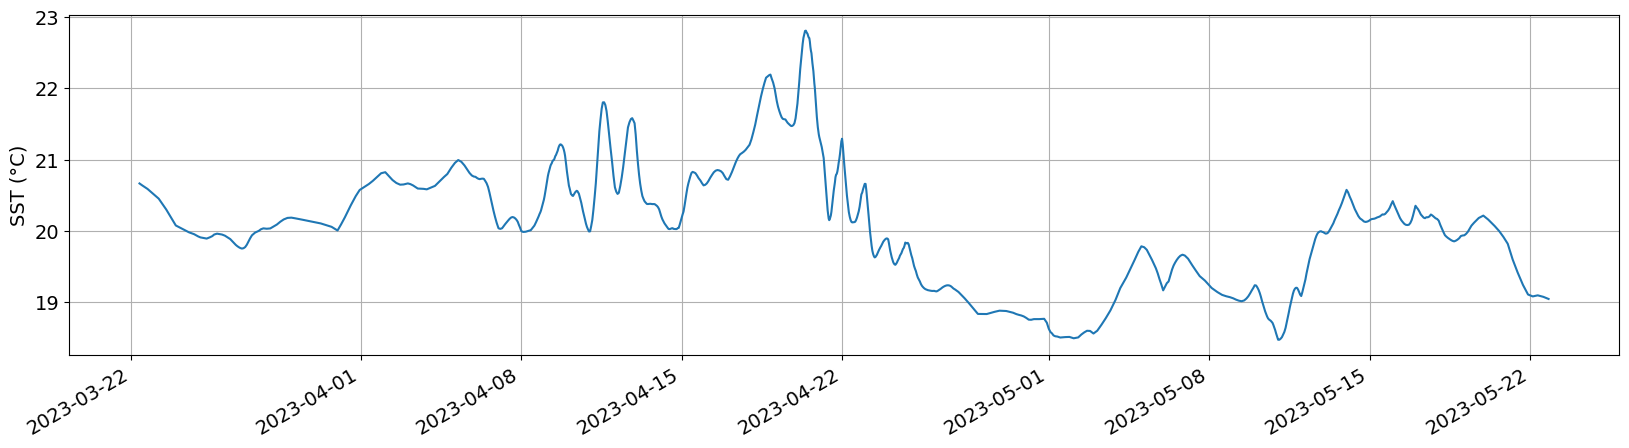

In [43]:
plt.figure(figsize=(20,5))
plt.plot(SST_global_glider.time,SST_global_glider, label='global')

# Set labels

plt.ylabel('SST (°C)')
plt.grid()

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

### SST in distance

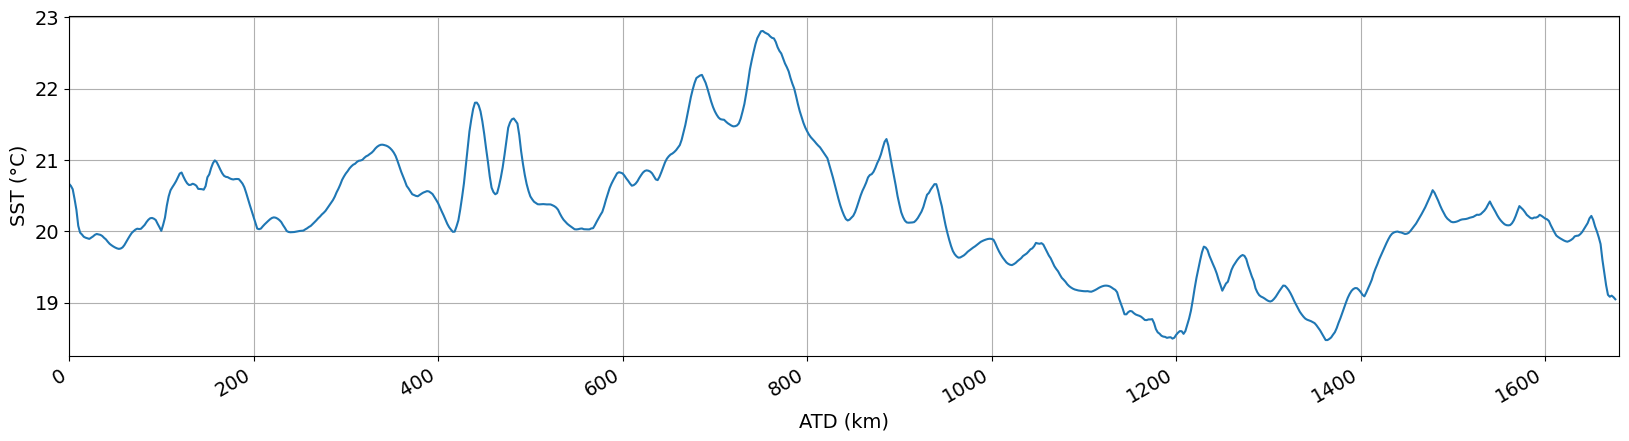

In [23]:
plt.figure(figsize=(20,5))
plt.plot(SST_global_glider.ATD,SST_global_glider, label='global')

# Set labels
plt.xlabel('ATD (km)')
plt.ylabel('SST (°C)')
plt.grid()
# Set x-axis ticks to have steps of 200
plt.xticks(np.arange(0, max(SST_global_glider.ATD) + 200, 200))
plt.xlim(0,1680)
# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Geostrophic speed against distance and time

In [31]:
import os

# Define start and end dates
start_date = pd.to_datetime("2023-03-22")
end_date = pd.to_datetime("2023-05-23")

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Generate a list of file paths for the given date range
file_paths = [file_path_pattern.format(current_date) for current_date in pd.date_range(start=start_date, end=end_date)]

# Filter out the paths that do not exist
existing_file_paths = [file_path for file_path in file_paths if os.path.exists(file_path)]

# Open multiple files as a single dataset
combined_ds = xr.open_mfdataset(existing_file_paths, combine='by_coords')

# Print the combined dataset
#combined_ds

In [32]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import cartopy.crs as ccrs
import numpy as np

# Define start and end dates
start_date = pd.to_datetime("2023-03-22")
end_date = pd.to_datetime("2023-05-23")


# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)

# Initialize a list to store image paths
image_paths = []

# Initialize lists to store ugos and vgos data for mean calculation
ugos_list = []
vgos_list = []

# Iterate over the dates to collect data for mean calculation
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Select ugos and vgos for the specified region
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)
    
    # Append data to the lists for mean calculation
    ugos_list.append(ugos)
    vgos_list.append(vgos)

# Concatenate all data arrays along the time dimension
ugos_all = xr.concat(ugos_list, dim='time')
vgos_all = xr.concat(vgos_list, dim='time')

# Calculate the magnitude of the velocity field
velocity_magnitude = np.sqrt(ugos_all**2 + vgos_all**2)


In [40]:
# Interpolate speed at the locations and times of the dataset
speed_at_temp_locs = velocity_magnitude.interp(
    latitude=ds_date['lat'],
    longitude=ds_date['long'],
    time=ds_date['time'],
    method="linear"
)

#speed_at_temp_locs

### Geostrophic current speed in time

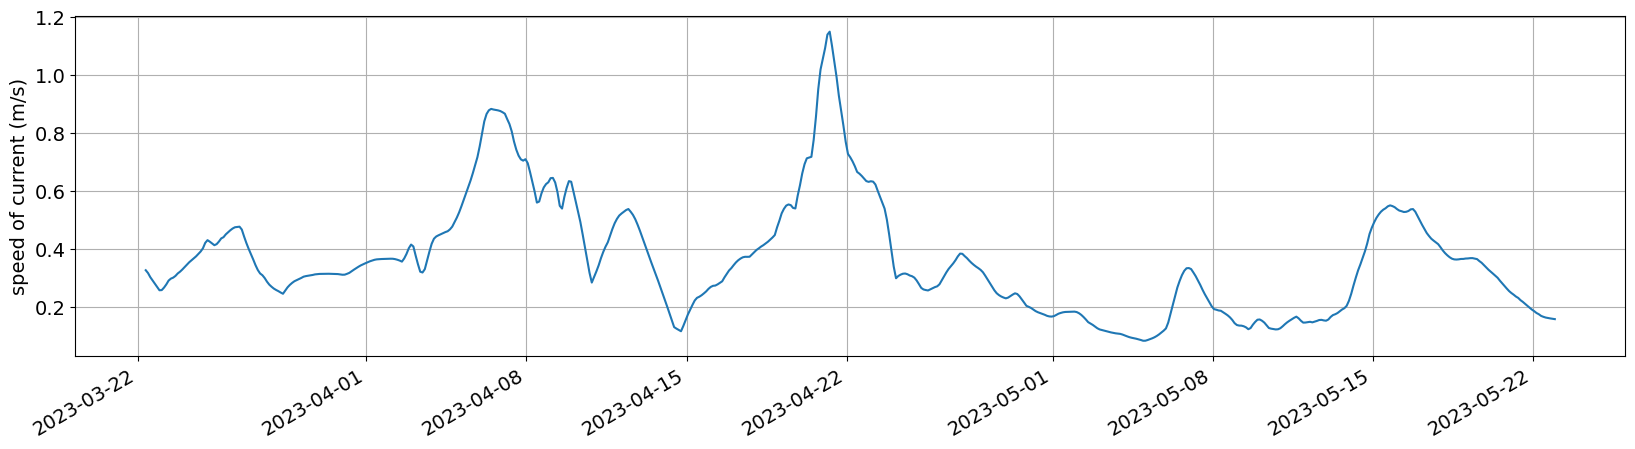

In [44]:
# Create a figure with a specific size
plt.figure(figsize=(20,5))

plt.plot(speed_at_temp_locs.time, speed_at_temp_locs, label='global')

# Set labels

plt.ylabel('speed of current (m/s)')
plt.grid()

# Set x-axis ticks to have steps of 200
#plt.xticks(np.arange(0, max(speed_global_glider.ATD) + 200, 200))

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

### Geostrophic current speed in distance

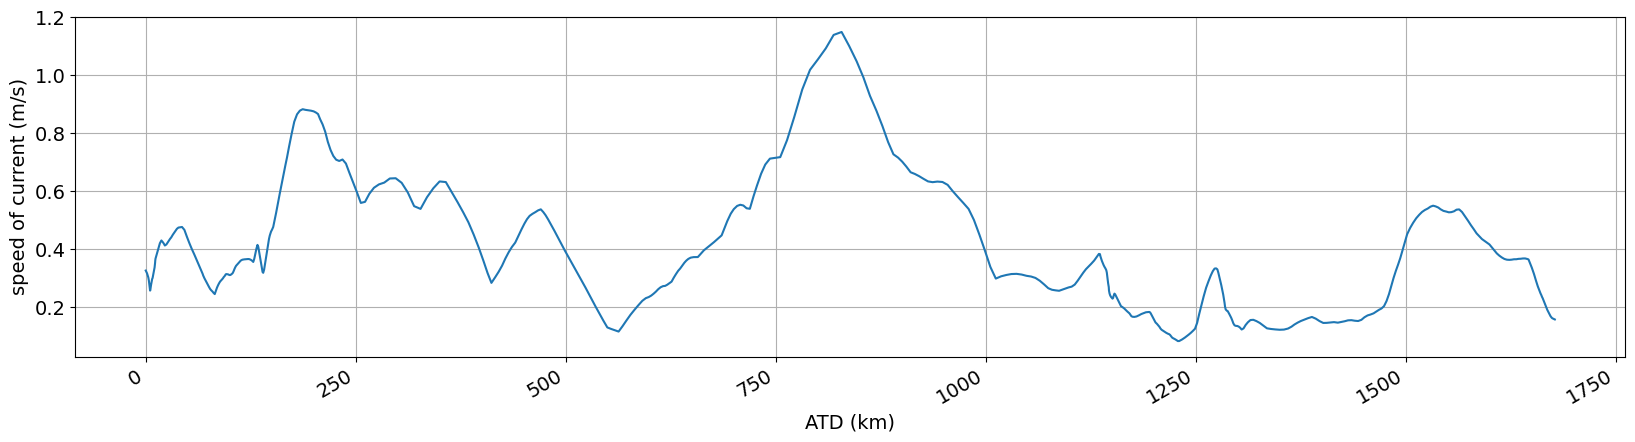

In [45]:
# Create a figure with a specific size
plt.figure(figsize=(20,5))

plt.plot(speed_at_temp_locs.distance, speed_at_temp_locs, label='global')

# Set labels
plt.xlabel('ATD (km)')
plt.ylabel('speed of current (m/s)')
plt.grid()

# Set x-axis ticks to have steps of 200
#plt.xticks(np.arange(0, max(speed_global_glider.ATD) + 200, 200))

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# EKE in space and time

In [46]:
import os

# Define start and end dates
start_date = pd.to_datetime("2023-03-22")
end_date = pd.to_datetime("2023-05-23")

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Generate a list of file paths for the given date range
file_paths = [file_path_pattern.format(current_date) for current_date in pd.date_range(start=start_date, end=end_date)]

# Filter out the paths that do not exist
existing_file_paths = [file_path for file_path in file_paths if os.path.exists(file_path)]

# Open multiple files as a single dataset
combined_ds = xr.open_mfdataset(existing_file_paths, combine='by_coords')

# Print the combined dataset
#combined_ds

In [55]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import cartopy.crs as ccrs
import numpy as np

# Define start and end dates
start_date = pd.to_datetime("2023-03-22")
end_date = pd.to_datetime("2023-05-23")


# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Select latitude and longitude range
lat_range = slice(-42, -32)
lon_range = slice(12, 21)

# Initialize a list to store image paths
image_paths = []

# Initialize lists to store ugos and vgos data for mean calculation
ugos_list = []
vgos_list = []

# Iterate over the dates to collect data for mean calculation
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Select ugos and vgos for the specified region
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)
    
    # Append data to the lists for mean calculation
    ugos_list.append(ugos)
    vgos_list.append(vgos)

# Concatenate all data arrays along the time dimension
ugos_all = xr.concat(ugos_list, dim='time')
vgos_all = xr.concat(vgos_list, dim='time')

# Calculate the mean over time
ugos_mean = ugos_all.mean(dim='time')
vgos_mean = vgos_all.mean(dim='time')


    
    # Select ugos and vgos for the specified region
ugos1 = combined_ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
vgos1 = combined_ds['vgos'].sel(latitude=lat_range, longitude=lon_range)
    
    # Calculate the deviations from the mean
ugos_anomaly = ugos1 - ugos_mean
vgos_anomaly = vgos1 - vgos_mean
    
    # Calculate EKE
eke = 0.5 * (ugos_anomaly**2 + vgos_anomaly**2)
#eke

In [56]:
# Load the datasets

#temp = ds_date.temp

# Ensure the temp dataset has latitude and longitude as coordinates
#temp = temp.assign_coords(lat=temp['lat'], lon=temp['long'])

# Interpolate SST at the locations and times of the temp dataset
eke_global_glider = eke.interp(
    latitude=ds_work['lat'],
    longitude=ds_work['long'],
    time=ds_work['time'],
    method="linear"
)

#eke_global_glider

### EKE in time

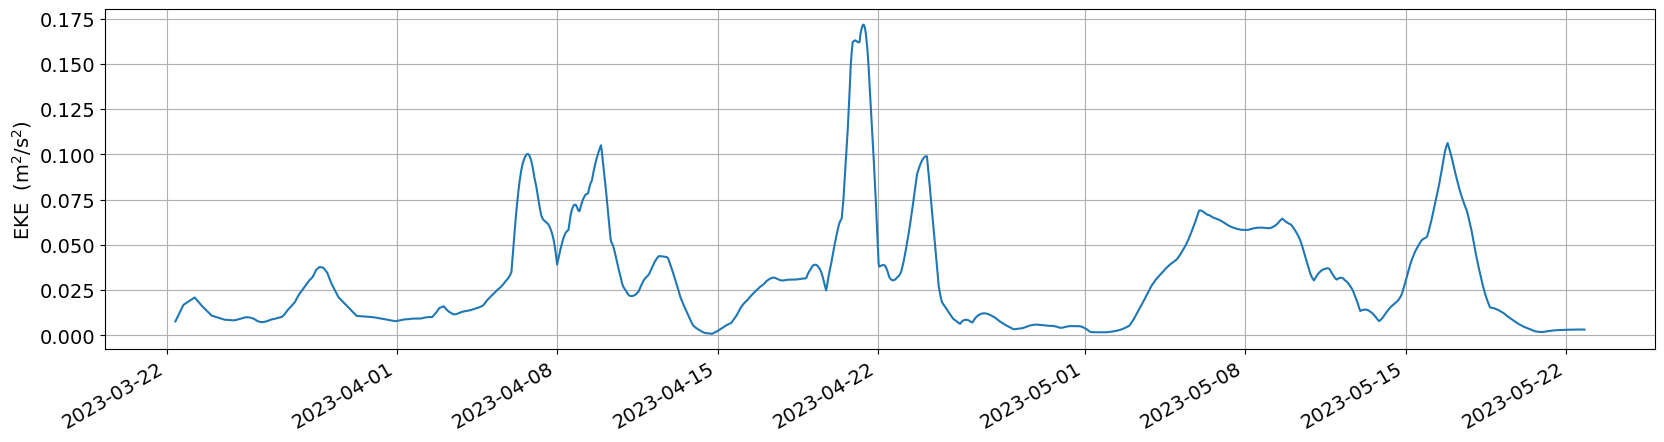

In [54]:
# Create a figure with a specific size
plt.figure(figsize=(20,5))

plt.plot(eke_global_glider.time, eke_global_glider, label='global')

# Set labels

plt.ylabel('EKE  (m$^2$/s$^2$)')
plt.grid()

# Set x-axis ticks to have steps of 200
#plt.xticks(np.arange(0, max(eke_global_glider.ATD)+ 200, 200))

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

### EKE in space

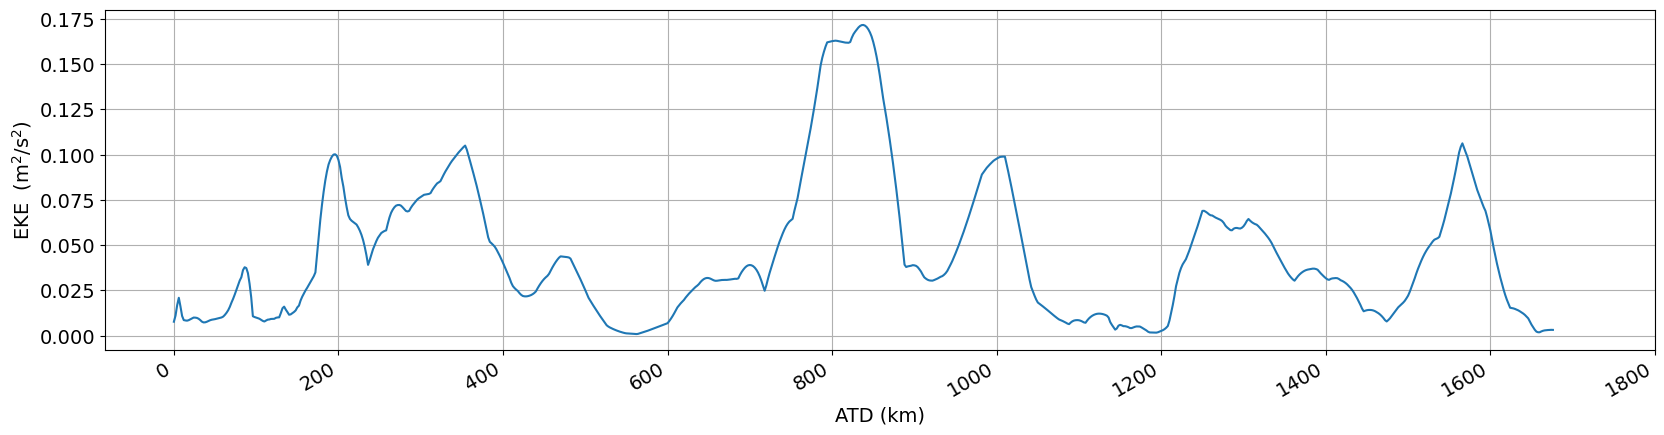

In [49]:
# Create a figure with a specific size
plt.figure(figsize=(20,5))

plt.plot(eke_global_glider.ATD, eke_global_glider, label='global')

# Set labels
plt.xlabel('ATD (km)')
plt.ylabel('EKE  (m$^2$/s$^2$)')
plt.grid()

# Set x-axis ticks to have steps of 200
plt.xticks(np.arange(0, max(eke_global_glider.ATD)+ 200, 200))

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Temperature gradient in space and time

In [57]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Define start and end dates
start_date = pd.to_datetime("2023-03-22")
end_date = pd.to_datetime("2023-05-23")


# vmin and vmax
vmin = -.05
vmax = 0.1
#cmap = 'balance'

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"


# Define the file path pattern
file_path_sst = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2_1716288824368.nc"

ds_sst = xr.open_dataset(file_path_sst)

# Select latitude and longitude range
lat_range = slice(-41, -33)
lon_range = slice(12, 20)

    
# Initialize lists to store gradients and corresponding coordinates
tempgrad_list = []
times = []


# Iterate over the dates
for current_date in pd.date_range(start=start_date, end=end_date):
    file_path = file_path_pattern.format(current_date)
    if not os.path.exists(file_path):  # Check if the file exists
        continue
    
    ds = xr.open_dataset(file_path)
    
    # Calculate EKE
    ugos = ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
    vgos = ds['vgos'].sel(latitude=lat_range, longitude=lon_range)

    latitude = ds['latitude']
    longitude = ds['longitude']
    # Extract sea surface height data for the specified region
    ssh_subset = ds['sla'].sel(latitude=lat_range, longitude=lon_range) # (Sea Level Anomaly)
    adt_subset = ds['adt'].sel(latitude=lat_range, longitude=lon_range) # (ADT)
    
    #plt.figure(figsize=(10, 6)) # Adjust the figure size to make space for the title
    # Create a map projection
    #ax = plt.axes(projection=ccrs.PlateCarree())
    
    
    # plot the SST 
    sst_subset = ds_sst['analysed_sst'].sel(latitude=lat_range, longitude=lon_range)
    
    sst_sel = sst_subset.sel(time=current_date, method='nearest')
    
    sst_sel_degree = sst_sel - 272.15
    
    # Compute the partial derivatives
    partial_lon = np.gradient(sst_sel_degree, axis=1)  # Gradient along longitude
    partial_lat = np.gradient(sst_sel_degree, axis=0)  # Gradient along latitude
    
    length_per_degree_lat = 111 # km
    
    length_per_degree_lon = 11 * np.cos(np.deg2rad(sst_sel_degree.latitude.values))
    
    # Convert the gradients to degrees per km
    partial_lon_per_km = partial_lon/0.05 / length_per_degree_lon
    partial_lat_per_km = partial_lat/0.05 / length_per_degree_lat

    # Sum the partial derivatives (now in degrees per km)
    tempgrad = np.absolute(partial_lon_per_km + partial_lat_per_km)
    
    # Append the results and time to the lists
    tempgrad_list.append(tempgrad)
    times.append(current_date)

# Convert lists to numpy arrays
tempgrad_array = np.array(tempgrad_list)
times_array = np.array(times)


# Create a new xarray Dataset to store the gradients with time, latitude, and longitude dimensions
ds_grad = xr.Dataset(
    {
        "tempgrad": (("time", "latitude", "longitude"), tempgrad_array)
    },
    coords={
        "time": times_array,
        "latitude": sst_subset.latitude,
        "longitude": sst_subset.longitude
    }
)

#ds_grad





In [58]:
# Load the datasets
#tempgrad= ds_grad.tempgrad
#temp = ds_date.temp

# Ensure the temp dataset has latitude and longitude as coordinates
#temp = temp.assign_coords(lat=temp['lat'], lon=temp['long'])

# Interpolate SST at the locations and times of the temp dataset
tempgrad_global_glider = ds_grad.interp(
    latitude=ds_work['lat'],
    longitude=ds_work['long'],
    time=ds_work['time'],
    method="linear"
)

#tempgrad_global_glider


### Temperature gradient against time

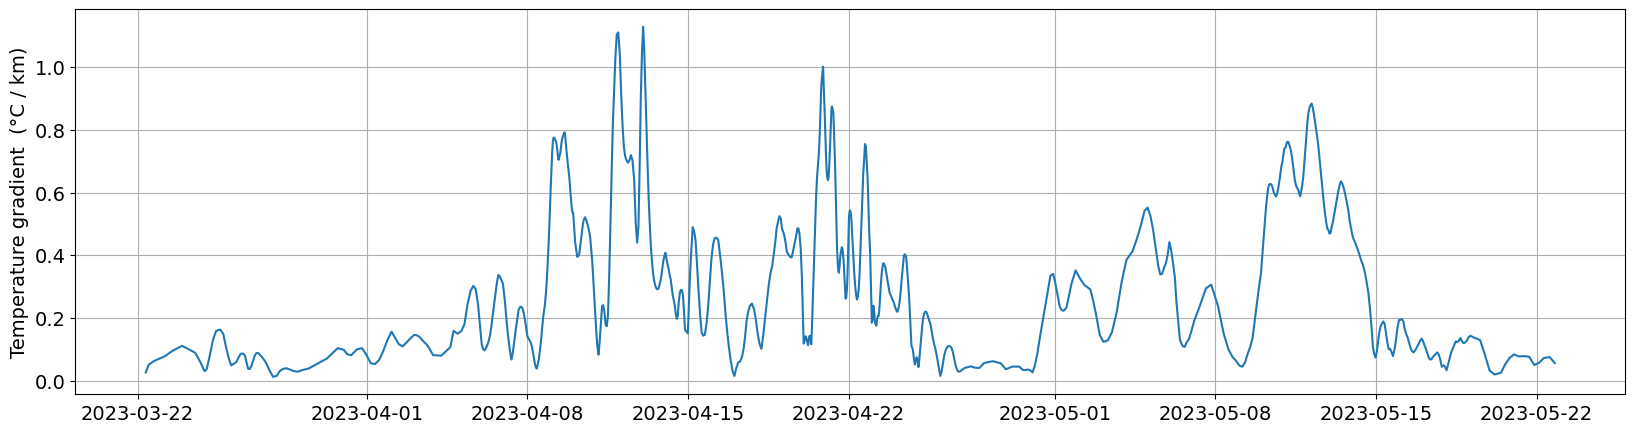

In [61]:
# Create a figure with a specific size
plt.figure(figsize=(20,5))

plt.plot(tempgrad_global_glider.time ,tempgrad_global_glider.tempgrad)
#plt.plot(AOU_integrated.ATD, AOU_integrated)

# Set labels

plt.ylabel('Temperature gradient  (°C / km)')
plt.grid()

# Set x-axis ticks to have steps of 200
#plt.xticks(np.arange(0, max(tempgrad_global_glider.ATD) + 200, 200))


### Temperature gradient against distance

([<matplotlib.axis.XTick at 0x2099a2f72d0>,
 [Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200'),
  Text(1400.0, 0, '1400'),
  Text(1600.0, 0, '1600'),
  Text(1800.0, 0, '1800')])

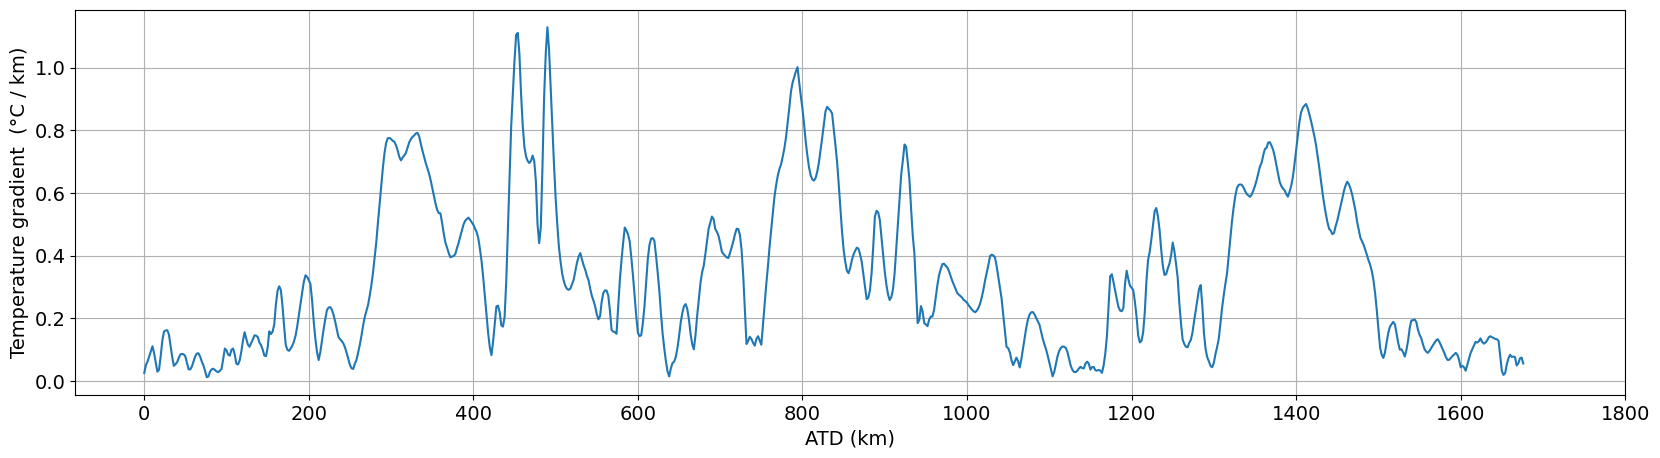

In [59]:
# Create a figure with a specific size
plt.figure(figsize=(20,5))

plt.plot(tempgrad_global_glider.ATD,tempgrad_global_glider.tempgrad)
#plt.plot(AOU_integrated.ATD, AOU_integrated)

# Set labels
plt.xlabel('ATD (km)')
plt.ylabel('Temperature gradient  (°C / km)')
plt.grid()

# Set x-axis ticks to have steps of 200
plt.xticks(np.arange(0, max(tempgrad_global_glider.ATD) + 200, 200))



# AOU below MLD and 300 - 700 m depth

In [63]:
# Define the depth range with MLD
depth_min_mld = mixed_layer_densities.ctd_depth
depth_max_mld = mixed_layer_densities.ctd_depth + 100

depth_min = 300
depth_max = 700


# Select AOU values within the depth range
AOU_subset = AOU.where((AOU.ctd_depth >= depth_min) & (AOU.ctd_depth <= depth_max), drop=True)
AOU_subset_mld = AOU.where((AOU.ctd_depth >= depth_min_mld) & (AOU.ctd_depth <= depth_max_mld), drop=True)

In [64]:
# Group AOU_subset by the 'ATD' dimension
AOU_grouped_mld = AOU_subset_mld.groupby('ATD')

# Compute the mean over 'ctd_depth' for each group
AOU_mean_mld = AOU_grouped_mld.mean(dim='ctd_depth')

#AOU_mean_mld

In [65]:
# Group AOU_subset by the 'ATD' dimension
AOU_grouped = AOU_subset.groupby('ATD')

# Compute the mean over 'ctd_depth' for each group
AOU_mean = AOU_grouped.mean(dim='ctd_depth')

#AOU_mean

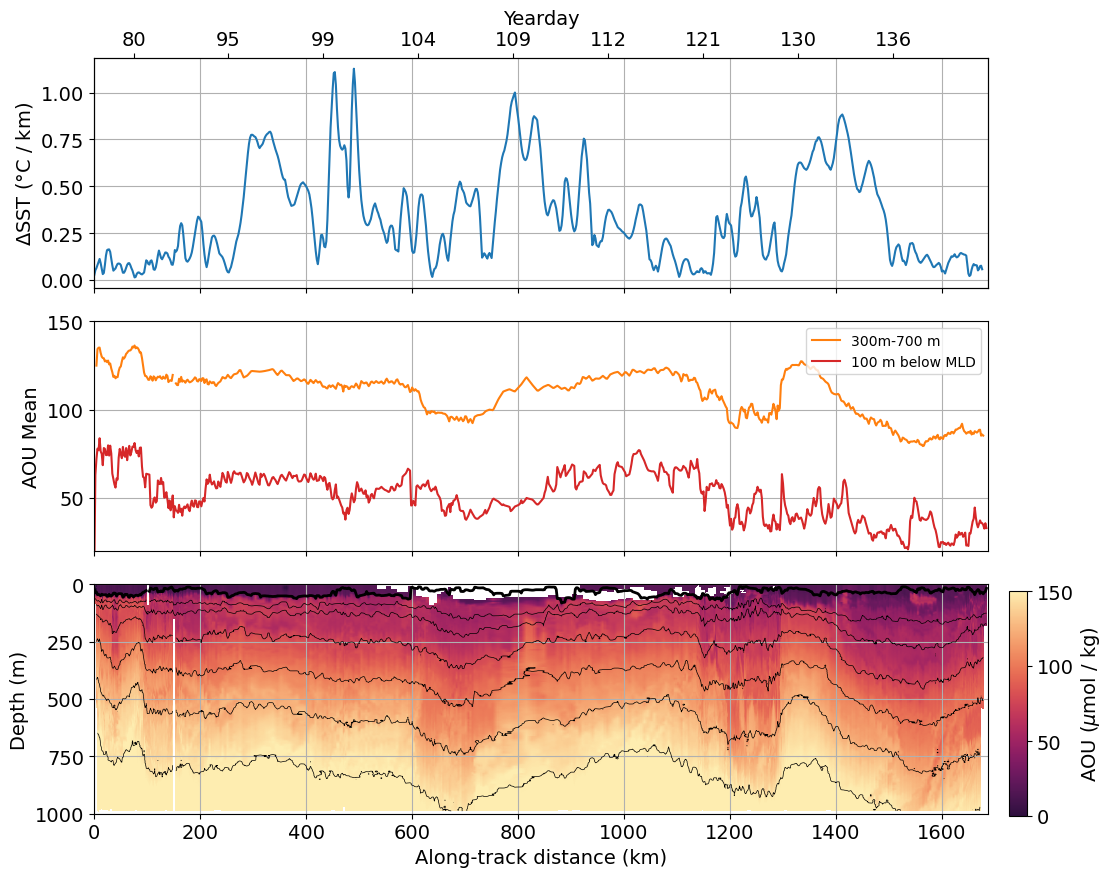

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with three subplots, one above the other
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 9), sharex=True)

# Plot the first dataset on the first axis
ax1.plot(tempgrad_global_glider.ATD, tempgrad_global_glider.tempgrad, label='Temperature Gradient')
ax1.set_ylabel('$\Delta$SST (°C / km)')
ax1.grid()
ax1.set_xticks(np.arange(0, max(tempgrad_global_glider.ATD) + 200, 200))

#ax1.set_title('Temperature Gradient vs ATD')

# Add the xlabel and yearday label on the top
ax0 = ax1.twiny()
ax0.set_xlabel('Yearday')

tick_positions = np.arange(0, max(ds_work.ATD), 200)
tick_labels = ds_work.year_day[np.searchsorted(ds_work.ATD, tick_positions)].astype(int)  # Convert to integers
ax0.set_xlim(ax1.get_xlim())
ax0.set_xticks(tick_positions)
ax0.set_xticklabels([f'{t:.0f}' for t in tick_labels])

ax0.tick_params(axis='x', which='major', labelsize='14')

# Plot the second dataset on the second axis
ax2.plot(AOU_mean.ATD, AOU_mean, color='tab:orange', label='300m-700 m')
ax2.plot(AOU_mean_mld.ATD, AOU_mean_mld, color='tab:red', label='100 m below MLD')
ax2.set_ylabel('AOU Mean')
ax2.set_ylim(20, 150)  # Set the y-axis limits for ax2
ax2.grid()
ax2.legend(loc='upper right', fontsize=10)
#ax2.set_title('AOU Mean vs ATD')



density = gsw.sigma0(ds_work.salinity, ds_work.temp)
AOU = ds_work.sol - ds_work.o2

# Create the bar chart for the third panel
img3 = ax3.pcolormesh(ds_work.ATD, ds_work.ctd_depth, AOU, cmap=cmo.matter_r, vmin=0, vmax=150)
ax3.invert_yaxis()

ax3.set_ylabel('Depth (m)')
ax3.set_xlabel('Along-track distance (km)')
ax3.grid()

# Generate levels for the contour lines
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

ax3.contour(ds_work.ATD, ds_work.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax3.plot(mixed_layer_densities.ATD, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Add the colorbar separately
fig.subplots_adjust(right=0.85)  # Adjust the right side of the plot to make space for the colorbar
cbar_ax = fig.add_axes([0.85, 0.08, 0.015, 0.25])  # [left, bottom, width, height]
cbar3 = fig.colorbar(img3, cax=cbar_ax)
cbar3.set_label(r'AOU ($\mu$mol / kg)')

# Adjust the layout to make space for the titles and labels
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make space for the colorbar

# Show the plot
plt.show()



# AOU with EKE and SST at 300 - 700 m depth

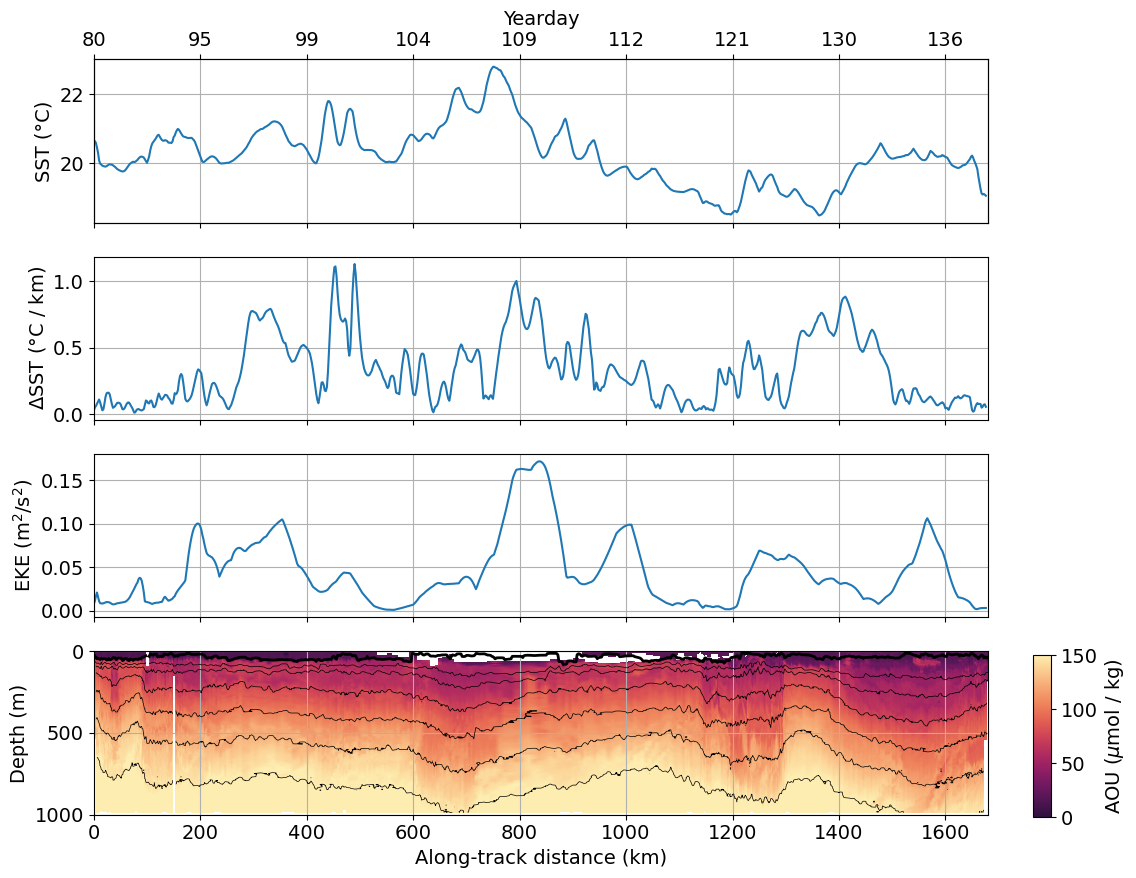

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean  # Assuming cmocean is used for the colormap
import gsw  # Assuming gsw is used for density calculation

# Data preparation (Assuming the datasets are already defined)
# SST_global_glider, tempgrad_global_glider, eke_global_glider, ds_work, AOU_mean, AOU_mean_mld, mixed_layer_densities

# Create a figure with four subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 9), sharex=True)

# Plot the first dataset on the first axis (SST vs ATD)
ax1.plot(SST_global_glider.ATD, SST_global_glider, label='Global')
ax1.set_ylabel('SST (°C)')
ax1.grid()
ax1.set_xticks(np.arange(0, max(SST_global_glider.ATD) + 200, 200))
ax1.set_xlim(0, 1680)


# Add the xlabel and yearday label on the top
ax0 = ax1.twiny()
ax0.set_xlabel('Yearday')
tick_positions = np.arange(0, max(ds_work.ATD), 200)
tick_labels = ds_work.year_day[np.searchsorted(ds_work.ATD, tick_positions)].astype(int)  # Convert to integers
ax0.set_xlim(ax1.get_xlim())
ax0.set_xticks(tick_positions)
ax0.set_xticklabels([f'{t:.0f}' for t in tick_labels])
ax0.tick_params(axis='x', which='major', labelsize=14)

# Plot the second dataset on the second axis (Temperature Gradient vs ATD)
ax2.plot(tempgrad_global_glider.ATD, tempgrad_global_glider.tempgrad)
ax2.set_ylabel('$\Delta$SST (°C / km)')
ax2.grid()
ax2.set_xticks(np.arange(0, max(tempgrad_global_glider.ATD) + 200, 200))
ax2.set_xlim(0, 1680)

# Plot the third dataset on the third axis (EKE vs ATD)
ax3.plot(eke_global_glider.ATD, eke_global_glider, label='Global')
ax3.set_ylabel('EKE (m$^2$/s$^2$)')
ax3.grid()
ax3.set_xticks(np.arange(0, max(eke_global_glider.ATD) + 200, 200))
ax3.set_xlim(0, 1680)

# Plot the fourth dataset on the fourth axis (AOU vs ATD and Depth)
density = gsw.sigma0(ds_work.salinity, ds_work.temp)
AOU = ds_work.sol - ds_work.o2
img4 = ax4.pcolormesh(ds_work.ATD, ds_work.ctd_depth, AOU, cmap=cmocean.cm.matter_r, vmin=0, vmax=150)
ax4.invert_yaxis()
ax4.set_ylabel('Depth (m)')
ax4.set_xlabel('Along-track distance (km)')
ax4.set_xlim(0, 1680)
ax4.grid()

# Generate levels for the contour lines
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)
ax4.contour(ds_work.ATD, ds_work.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax4.plot(mixed_layer_densities.ATD, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Add the colorbar separately
fig.subplots_adjust(right=0.85)  # Adjust the right side of the plot to make space for the colorbar
cbar_ax = fig.add_axes([0.87, 0.08, 0.015, 0.18])  # [left, bottom, width, height]
cbar4 = fig.colorbar(img4, cax=cbar_ax)
cbar4.set_label(r'AOU ($\mu$mol / kg)')

# Adjust the layout to make space for the titles and labels
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make space for the colorbar

# Show the plot
plt.show()




# ADT in space and time

In [68]:

import os

# Define start and end dates
start_date = pd.to_datetime("2023-03-22")
end_date = pd.to_datetime("2023-05-23")

# Define the file path pattern
file_path_pattern = "C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/may/dt_global_twosat_phy_l4_{:%Y%m%d}_vDT2021.nc"

# Generate a list of file paths for the given date range
file_paths = [file_path_pattern.format(current_date) for current_date in pd.date_range(start=start_date, end=end_date)]

# Filter out the paths that do not exist
existing_file_paths = [file_path for file_path in file_paths if os.path.exists(file_path)]

# Open multiple files as a single dataset
combined_ds = xr.open_mfdataset(existing_file_paths, combine='by_coords')

# Print the combined dataset
#combined_ds

In [70]:
# Load the datasets
adt = combined_ds.adt

# Interpolate SST at the locations and times of the temp dataset
adt_at_temp_locs = adt.interp(
    latitude=ds_work['lat'],
    longitude=ds_work['long'],
    time=ds_work['time'],
    method="linear"
)

#adt_at_temp_locs


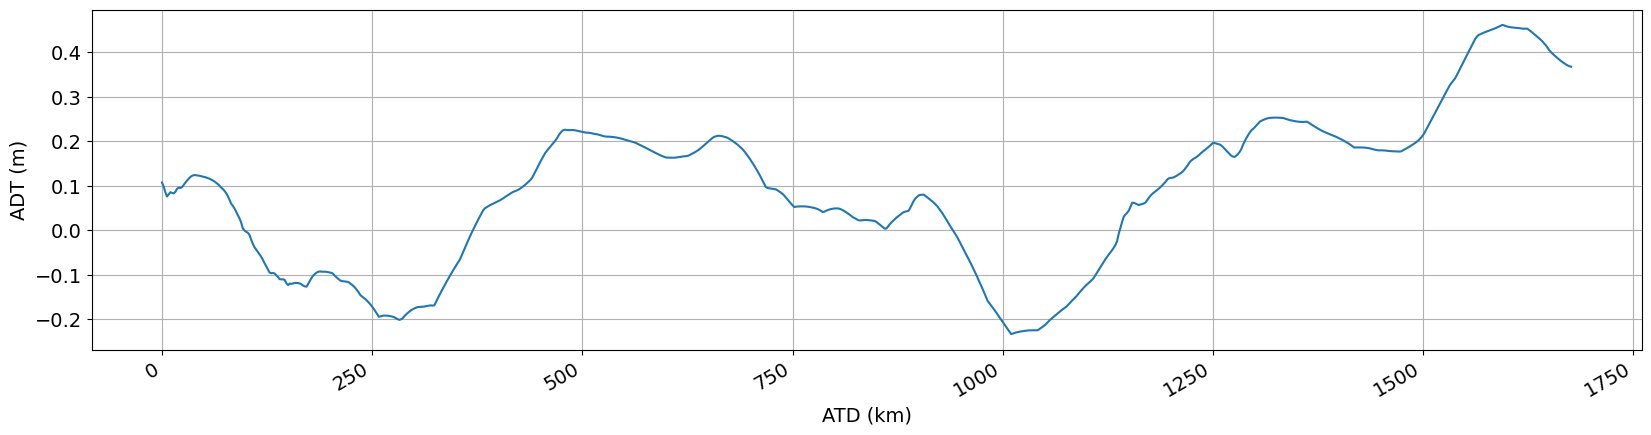

In [71]:
# Create a figure with a specific size
plt.figure(figsize=(20,5))
plt.plot(adt_at_temp_locs.ATD,adt_at_temp_locs)

# Set labels
plt.xlabel('ATD (km)')
plt.ylabel('ADT (m)')
plt.grid()

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

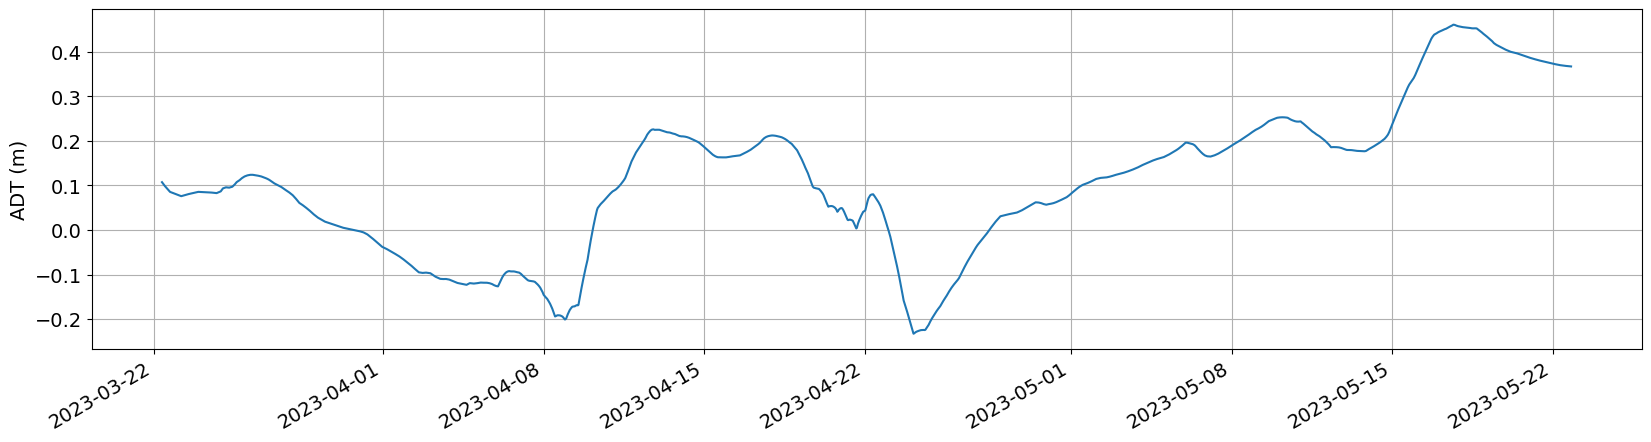

In [73]:
# Create a figure with a specific size
plt.figure(figsize=(20,5))
plt.plot(adt_at_temp_locs.time,adt_at_temp_locs)

# Set labels

plt.ylabel('ADT (m)')
plt.grid()

# Set x-axis ticks to have steps of 200
#plt.xticks(np.arange(0, max(tempgrad_global_glider.ATD) + 200, 200))

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# EKE along time and ATD

In [74]:
# Select latitude and longitude range
lat_range = slice(-41, -32)
lon_range = slice(12, 21)

# Calculate EKE
ugos = combined_ds['ugos'].sel(latitude=lat_range, longitude=lon_range)
vgos = combined_ds['vgos'].sel(latitude=lat_range, longitude=lon_range)
eke = 0.5 * (ugos ** 2 + vgos ** 2)

temp = ds_date.temp

# Ensure the temp dataset has latitude and longitude as coordinates
temp = temp.assign_coords(lat=temp['lat'], lon=temp['long'])

# Interpolate SST at the locations and times of the temp dataset
eke_at_temp_locs = eke.interp(
    latitude=temp['lat'],
    longitude=temp['long'],
    time=temp['time'],
    method="linear"
)

#eke_at_temp_locs

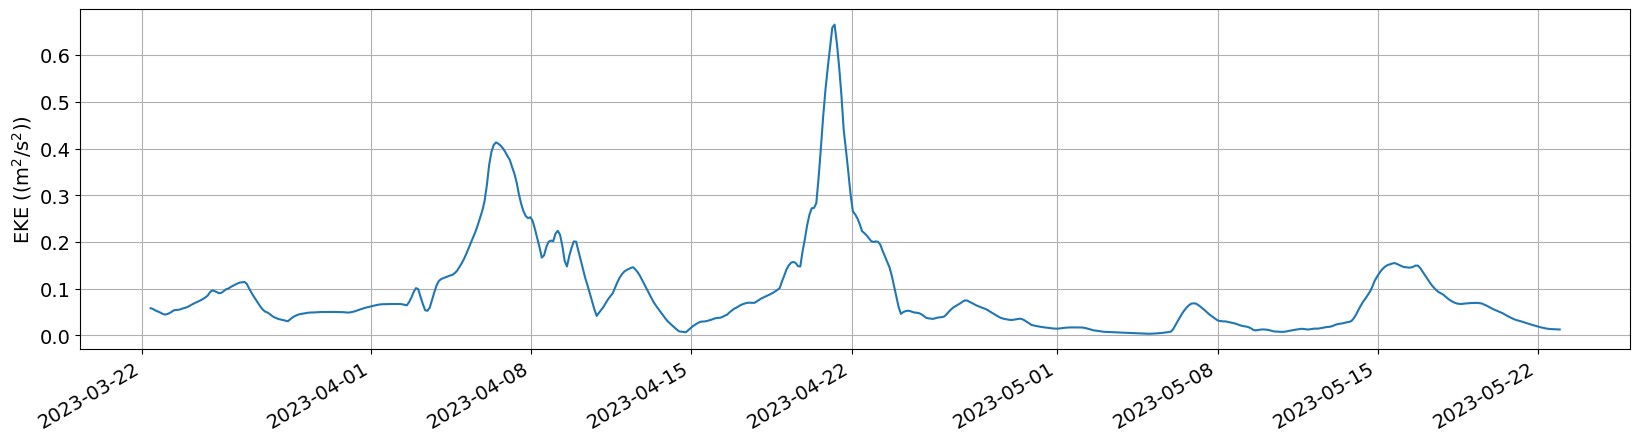

In [77]:
plt.figure(figsize=(20,5))
plt.plot(eke_at_temp_locs.time,eke_at_temp_locs, label='global')

# Set labels

plt.ylabel('EKE ((m$^2$/s$^2$))')
plt.grid()

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

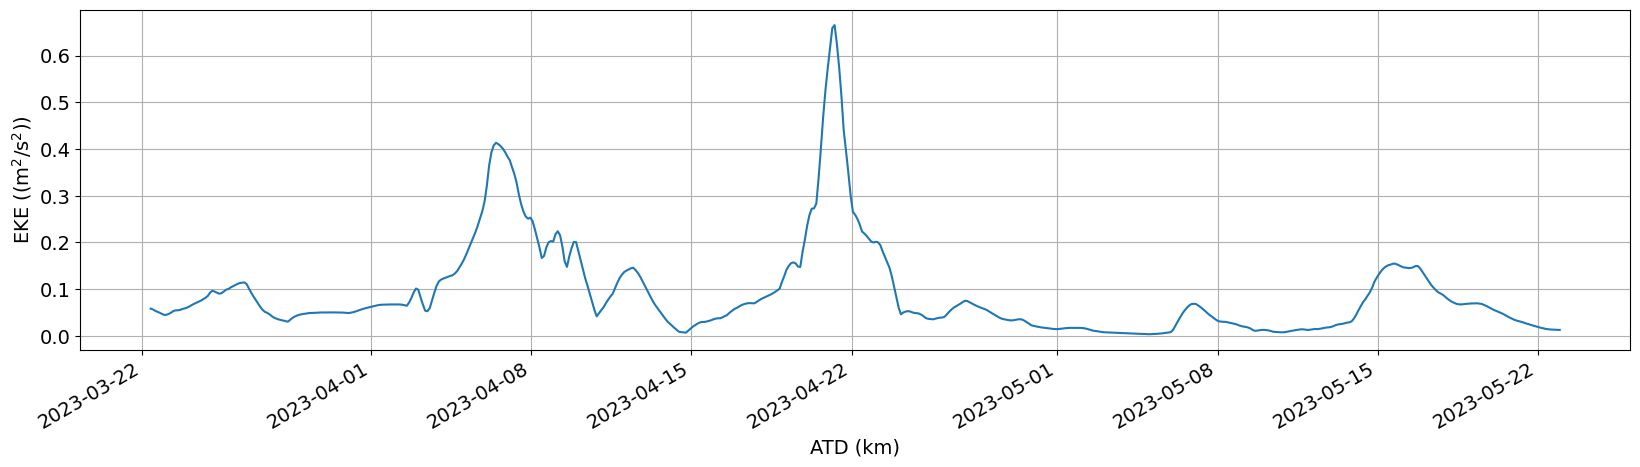

In [78]:
plt.figure(figsize=(20,5))
plt.plot(eke_at_temp_locs.time,eke_at_temp_locs, label='global')

# Set labels
plt.xlabel('ATD (km)')
plt.ylabel('EKE ((m$^2$/s$^2$))')
plt.grid()

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Resolution density

In [81]:
density = gsw.sigma0(ds_work.salinity, ds_work.temp)
delta_rho = np.diff(density)
np.shape(delta_rho)
#delta_rho

(2001, 843)

# Grid along density for all variables

In [82]:
density = gsw.sigma0(ds_work.salinity, ds_work.temp)
den_grid_002 = np.arange(np.min(density), np.max(density)+0.002, 0.002)

def grid_to_den(density, var, den_grid):
    
    var_grid = np.ndarray([var.ATD.size, den_grid.size])
    
    for v in range(var.ATD.size):
        
        density_profile = density.isel(ATD=v)
        var_profile = var.isel(ATD=v)
    
        ind_sort = np.argsort(density_profile.data)
        den_sort = np.sort(density_profile.data)

        var_grid[v] = griddata(den_sort, var_profile[ind_sort], den_grid)
        
    return var_grid

In [83]:
ox_sol = gsw.O2sol(ds_work.salinity, ds_work.temp, ds_work.p, ds_work.long, ds_work.lat)

In [84]:
temp_den_grid_002 = grid_to_den(density, ds_work.temp, den_grid_002)
sal_den_grid_002 = grid_to_den(density, ds_work.salinity, den_grid_002)
ox_den_grid_002 = grid_to_den(density, ds_work.o2, den_grid_002)
sol_den_grid_002 = grid_to_den(density, ox_sol, den_grid_002)

### Create dataset gridded in density

In [96]:
# Create a Dataset with dimensions ctd_depth and ATD
ds_den = xr.Dataset(
    {'temp': (['density', 'ATD'], temp_den_grid_002.T),
     'salinity': (['density', 'ATD'], sal_den_grid_002.T),
     'o2': (['density', 'ATD'], ox_den_grid_002.T),
     'sol': (['density', 'ATD'], sol_den_grid_002.T)},
    coords={'density': den_grid_002,
            'ATD': ds_work.ATD,}
)

# Add attributes to the dataset
ds_den.attrs['description'] = 'dataset including gridded data in density and ATD with cleaned variables'


ds_den

<xarray.Dataset>
Dimensions:   (density: 1614, ATD: 844)
Coordinates:
  * density   (density) float64 24.37 24.37 24.37 24.38 ... 27.59 27.59 27.6
  * ATD       (ATD) float64 0.0 2.0 4.0 6.0 ... 1.682e+03 1.684e+03 1.686e+03
Data variables:
    temp      (density, ATD) float64 nan nan nan nan nan ... nan nan nan nan nan
    salinity  (density, ATD) float64 nan nan nan nan nan ... nan nan nan nan nan
    o2        (density, ATD) float64 nan nan nan nan nan ... nan nan nan nan nan
    sol       (density, ATD) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  dataset including gridded data in density and ATD with clea...

In [97]:
ds_den.to_netcdf('ds_den.nc')

NameError: name 'colorbar_ax0' is not defined

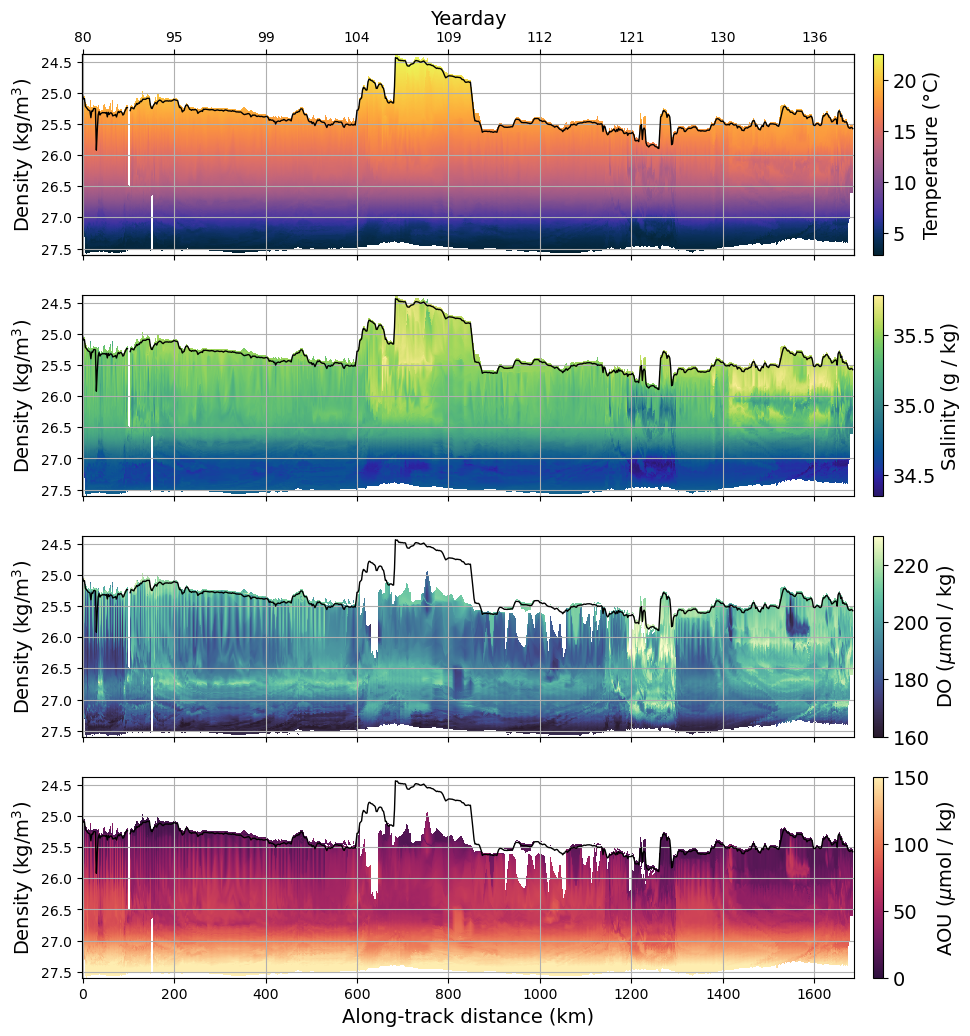

In [85]:
fig, ax = plt.subplots(4, figsize=(12, 12), sharex=True)

vmin = 160
vmax = 230

density = gsw.sigma0(sal_den_grid_002, temp_den_grid_002)
AOU = sol_den_grid_002 - ox_den_grid_002

# Create the bar chart
img0 = ax[0].pcolormesh(ds_work.ATD, den_grid_002, temp_den_grid_002.T, cmap = cmo.thermal)
img1 = ax[1].pcolormesh(ds_work.ATD, den_grid_002, sal_den_grid_002.T, cmap = cmo.haline)
img2 = ax[2].pcolormesh(ds_work.ATD, den_grid_002, ox_den_grid_002.T, cmap = cmo.deep_r, vmin =160, vmax=230)
img3 = ax[3].pcolormesh(ds_work.ATD, den_grid_002, AOU.T, cmap = cmo.matter_r, vmin = 0, vmax = 150)

[a.invert_yaxis() for a in ax]
# Add colorbars to the plots
cbar0 = plt.colorbar(img0, ax=ax[0], pad=0.02)
cbar0.set_label('Temperature (°C)')

cbar1 = plt.colorbar(img1, ax=ax[1], pad=0.02)
cbar1.set_label('Salinity (g / kg)')

cbar2 = plt.colorbar(img2, ax=ax[2], pad=0.02)
cbar2.set_label(r'DO ($\mu$mol / kg)')

cbar3 = plt.colorbar(img3, ax=ax[3], pad=0.02)
cbar3.set_label(r'AOU ($\mu$mol / kg)')





#ax[0].set_title('Temperature')
#ax[1].set_title('Salinity')
#ax[2].set_title('DO')
#ax[3].set_title('AOU')

ax[3].set_xlabel('Along-track distance (km)')
ax[0].set_ylabel(r'Density (kg/m$^3$)')
ax[1].set_ylabel(r'Density (kg/m$^3$)')
ax[2].set_ylabel(r'Density (kg/m$^3$)')
ax[3].set_ylabel(r'Density (kg/m$^3$)')

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

# Generate levels for the contour lines
# Specify the beginning, ending, and spacing
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)


ax[0].plot(mixed_layer_densities.ATD, mixed_layer_densities, color='k', linewidth =1)
ax[1].plot(mixed_layer_densities.ATD, mixed_layer_densities, color='k', linewidth =1)
ax[2].plot(mixed_layer_densities.ATD, mixed_layer_densities, color='k', linewidth =1)
ax[3].plot(mixed_layer_densities.ATD, mixed_layer_densities, color='k', linewidth =1)



# Increase font sizes for all text and numbers
plt.rcParams.update({'font.size': 14})  # Set the default font size






# Set the xlabel on the top
ax0 = ax[0].twiny()
ax0.set_xlabel('Yearday')



tick_positions = np.arange(0, max(ds_work.ATD), 200)
tick_labels = ds_work.year_day[np.searchsorted(ds_work.ATD, tick_positions)].astype(int)  # Convert to integers
ax0.set_xlim(ax[0].get_xlim())
ax0.set_xticks(tick_positions)
ax0.set_xticklabels([f'{t:.0f}' for t in tick_labels])

ax0.tick_params(axis='x', which='major', labelsize='10')

# Set font sizes for specific elements
for a in ax:
    a.set_title(a.get_title(), fontsize=14)  # Increase title font size
    a.set_xlabel(a.get_xlabel(), fontsize=14)  # Increase x-axis label font size
    a.set_ylabel(a.get_ylabel(), fontsize=14)  # Increase y-axis label font size
    a.tick_params(axis='both', which='major', labelsize=10)  # Increase tick label font size

colorbar_ax0.tick_params(axis='both', which='major', labelsize=10)     
colorbar_ax1.tick_params(axis='both', which='major', labelsize=10)  # Increase colorbar tick label font size
colorbar_ax2.tick_params(axis='both', which='major', labelsize=10)  
colorbar_ax3.tick_params(axis='both', which='major', labelsize=10)  

# Increase font size for colorbar labels
colorbar_ax0.set_ylabel(colorbar_ax0.get_ylabel(), fontsize=12) 
colorbar_ax1.set_ylabel(colorbar_ax1.get_ylabel(), fontsize=12)  
colorbar_ax2.set_ylabel(colorbar_ax2.get_ylabel(), fontsize=12)  
colorbar_ax3.set_ylabel(colorbar_ax3.get_ylabel(), fontsize=12)  



# Save the figure
plt.savefig('CombinedATD.png', bbox_inches='tight', dpi=100)

# plot in TS space

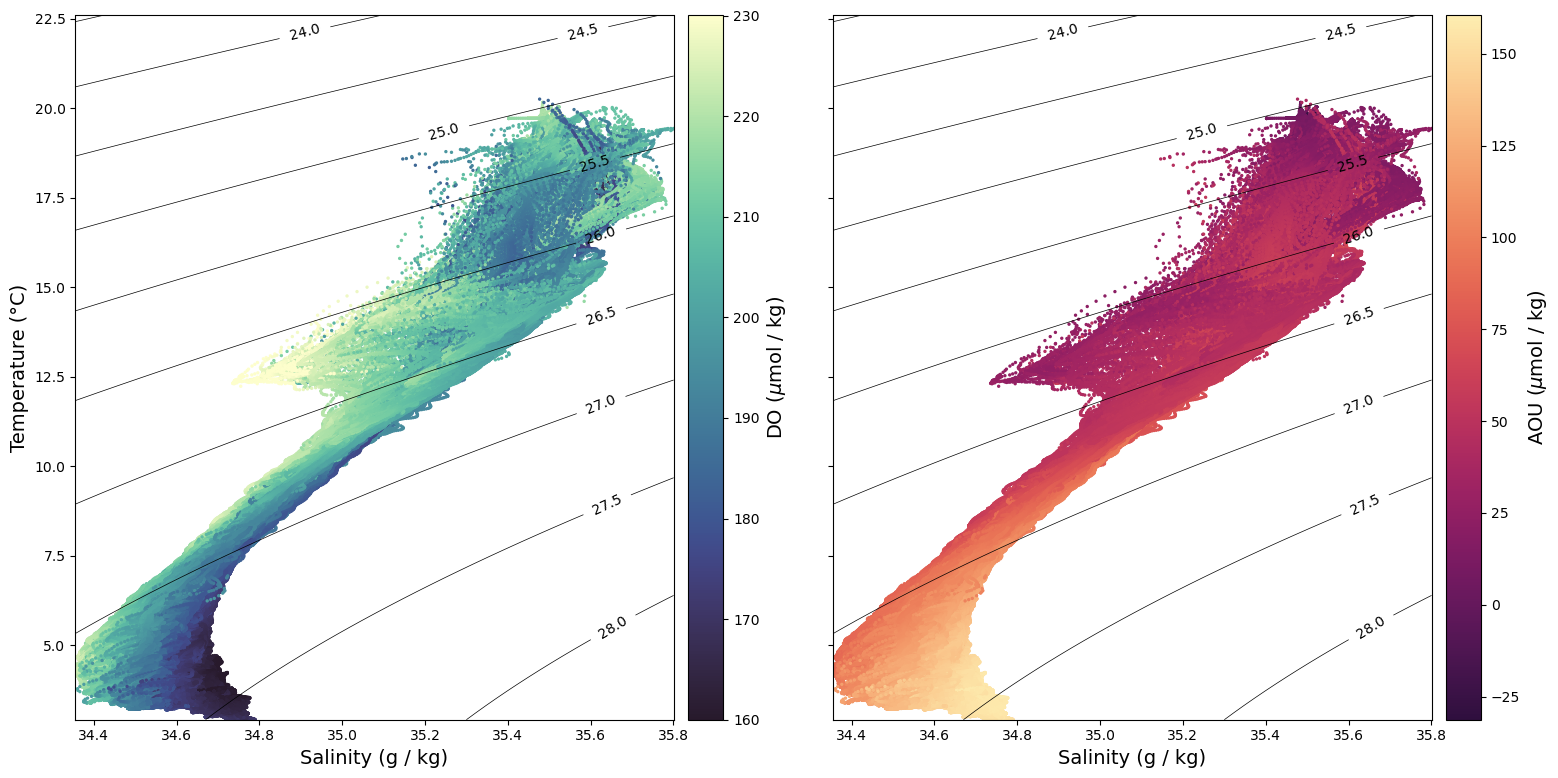

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import gsw
import cmocean.cm as cmo

# Assuming ds_work is a dataset with salinity, temperature, o2, and sol (oxygen saturation) data
# For example: ds_work = xr.Dataset({'salinity': ..., 'temp': ..., 'o2': ..., 'sol': ...})

fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

vmin = 160
vmax = 230

# Calculate density and AOU
density = gsw.sigma0(ds_work.salinity, ds_work.temp)
AOU = ds_work.sol - ds_work.o2

# Create the scatter plots with smaller dots (e.g., s=10)
img0 = ax[0].scatter(ds_work.salinity, ds_work.temp, c=ds_work.o2, cmap=cmo.deep_r, vmin=vmin, vmax=vmax, s=2)
img1 = ax[1].scatter(ds_work.salinity, ds_work.temp, c=AOU, cmap=cmo.matter_r, s=2)

# Add colorbars to the plots
cbar0 = plt.colorbar(img0, ax=ax[0], pad=0.02)
cbar0.set_label(r'DO ($\mu$mol / kg)')

cbar1 = plt.colorbar(img1, ax=ax[1], pad=0.02)
cbar1.set_label(r'AOU ($\mu$mol / kg)')

# Set axis labels
ax[0].set_xlabel('Salinity (g / kg)')
ax[0].set_ylabel('Temperature (°C)')
ax[1].set_xlabel('Salinity (g / kg)')

# Generate density contour levels
levels = np.arange(22, 30, 0.5)

# Create a grid of salinity and temperature
salinity_range = np.linspace(ds_work.salinity.min(), ds_work.salinity.max(), 100)
temperature_range = np.linspace(ds_work.temp.min(), ds_work.temp.max(), 100)
S_grid, T_grid = np.meshgrid(salinity_range, temperature_range)

# Calculate density on the grid
density_grid = gsw.sigma0(S_grid, T_grid)

# Add contour lines
contours0 = ax[0].contour(S_grid, T_grid, density_grid, levels=levels, colors='k', linewidths=0.5)
contours1 = ax[1].contour(S_grid, T_grid, density_grid, levels=levels, colors='k', linewidths=0.5)

# Add labels to contour lines
ax[0].clabel(contours0, inline=True, fontsize=10, fmt='%1.1f')
ax[1].clabel(contours1, inline=True, fontsize=10, fmt='%1.1f')

# Increase font sizes for all text and numbers
plt.rcParams.update({'font.size': 14})

#plt.grid()

# Set font sizes for specific elements
for a in ax:
    a.set_title(a.get_title(), fontsize=14)
    a.set_xlabel(a.get_xlabel(), fontsize=14)
    a.set_ylabel(a.get_ylabel(), fontsize=14)
    a.tick_params(axis='both', which='major', labelsize=10)
    a.invert_yaxis()

# Ensure colorbar tick labels are also adjusted
cbar0.ax.tick_params(axis='both', which='major', labelsize=10)
cbar1.ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()
